# Load Lib

In [1]:
#Homemade Functions
from functions.functions_analysis import *
from functions.Path_combine_function import *
from functions.plot_functions import *
from functions.Preproc_functions import *

#More nifti packages
from nilearn import plotting
import nibabel as nib

import matplotlib.pyplot as plt
import numpy as np

# Dipy
import dipy as dp
from dipy.io.image import load_nifti, save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.data as dpd

#Preproc
from dipy.align import motion_correction
import dipy.direction.peaks as dpp
from dipy.viz import window, actor
from dipy.segment.mask import median_otsu
from dipy.core.histeq import histeq

from dipy.denoise.nlmeans import nlmeans
from dipy.denoise.noise_estimate import estimate_sigma

#DIPY Plot
from dipy.viz import window, actor
from dipy.data import get_sphere

#Regular Packages
import keyboard  # For detecting keypresses
import IPython

import numpy as np
import os
import ants

from pathlib import Path
from time import time
import time  # For simulating work
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

In [9]:
def coeff_of_variation(profile):
    return np.nanstd(profile) / np.nanmean(profile)

# Plot 1 (T2 NMR signal simulation)

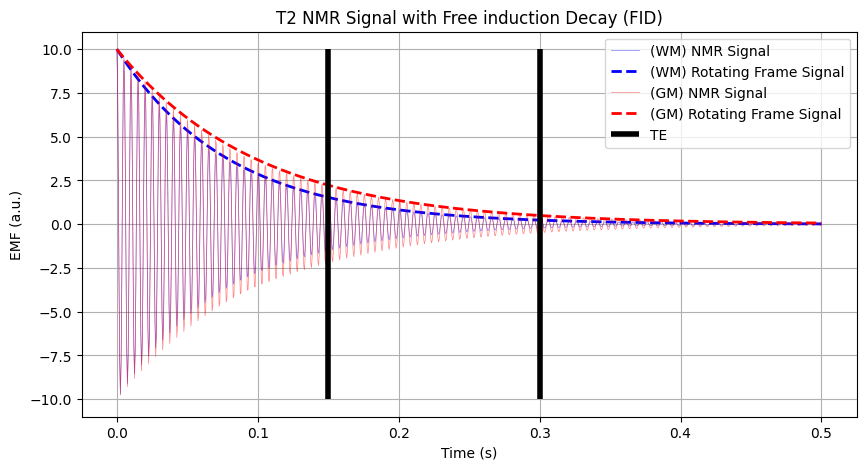

In [ ]:
def NMR_t2_signal(t, omega, T2,A):
    """
    Calculate the NMR signal at time t given T1, T2, and M0.
    """
    return A * np.cos(omega * t) * np.exp(-t / T2)

def omega(gamma, B0):
    """
    Calculate the Larmor frequency given the gyromagnetic ratio and magnetic field strength.
    """
    return gamma * B0

gamma = 42.58e6  # Gyromagnetic ratio for protons in Hz/T
B0 = 0.5  # Magnetic field strength in Tesla

omega_h = omega(gamma, B0)
omega_0 = 0

x = np.linspace(0, .5, 1000)

t2_wm = 0.08  # T2 relaxation time for white matter in seconds
t2_gm = 0.1  # T2 relaxation time for gray matter in seconds

A= 10 # Amplitude of the signal

NMR_wm = NMR_t2_signal(t=x, omega= omega_h, T2= t2_wm, A=A)
NMR_gm = NMR_t2_signal(t=x, omega= omega_h, T2= t2_gm, A=A)

# Transistion to the rotation frame: I.e., omega = 0
NMR_wm_RF = NMR_t2_signal(t=x, omega= omega_0, T2= t2_wm, A=A)
NMR_gm_RF = NMR_t2_signal(t=x, omega= omega_0, T2= t2_gm, A=A)



# Plotting the NMR signals
plt.figure(figsize=(10, 5))
plt.plot(x, NMR_wm, label='(WM) NMR Signal', color='blue', alpha = 0.5, linewidth = .5)
plt.plot(x, NMR_wm_RF, label = '(WM) Rotating Frame Signal', linestyle='--', color = "blue", linewidth = 2)
plt.plot(x, NMR_gm, label='(GM) NMR Signal', color='red', alpha = 0.5, linewidth = .5)
plt.plot(x, NMR_gm_RF, label = '(GM) Rotating Frame Signal', linestyle='--', color = "red", linewidth = 2)
plt.vlines([0.15,.3], ymin=-10, ymax=10, color='black', linestyle='-', label='TE', linewidth= 4)
#plt.vlines([0.3], ymin=-10, ymax=10, color='black', linestyle='-', label='TE = 0.3s')
plt.xlabel('Time (s)')
plt.ylabel('EMF (a.u.)')
plt.title('T2 NMR Signal with Free induction Decay (FID)')
plt.legend()
plt.grid()
plt.savefig('figures/NMR_FID_signal_plot.svg', dpi=600, bbox_inches='tight')
plt.show()


# Plot 2 (Bias field of individual images)

In [2]:
def compute_axis_profiles(data, mask=None):
    """
    Compute mean intensity profiles along x, y, and z axes.
    If a mask is provided, averages only within the mask.
    """
    if mask is not None:
        data = np.where(mask, data, np.nan)
    
    mean_x = np.nanmean(data, axis=(1, 2))  # mean along y-z plane
    mean_y = np.nanmean(data, axis=(0, 2))  # mean along x-z plane
    mean_z = np.nanmean(data, axis=(0, 1))  # mean along x-y plane
    
    return mean_x, mean_y, mean_z

In [4]:
#Find Files
file_paths = PathFinder("RARE_2D_Ax_preproc.nii")
mask_paths = PathFinder("RARE_mask.npy")

all_masked_means = []
for n in range(len(file_paths)):
    mask = np.load(mask_paths[n], allow_pickle=True)
    data, affine = load_nifti(file_paths[n])
    masked_means = []
    for i in range(data.shape[2]):
        slice_data = data[:, :, i]
        slice_mask = mask[:, :, i]
        mean_val = slice_data[slice_mask].mean() if np.any(slice_mask) else np.nan
        masked_means.append(mean_val)
    all_masked_means.append(np.array(masked_means))


#Find Files
file_paths_BFC = PathFinder("RARE_2D_Ax_preproc_BFC.nii")
mask_paths = PathFinder("RARE_mask.npy")

all_masked_means_BFC = []
for n in range(len(file_paths_BFC)):
    mask = np.load(mask_paths[n], allow_pickle=True)
    data_BFC, affine = load_nifti(file_paths_BFC[n])
    masked_means = []
    for i in range(data_BFC.shape[2]):
        slice_data = data_BFC[:, :, i]
        slice_mask = mask[:, :, i]
        mean_val = slice_data[slice_mask].mean() if np.any(slice_mask) else np.nan
        masked_means.append(mean_val)
    all_masked_means_BFC.append(np.array(masked_means))



['C:/DTI_SC/humanSC_400h\\190805-HumanSC\\89-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\92-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\95-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\98-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\101-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\104-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\107-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\110-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\113-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\116-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\119-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\122-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190812-HumanSC\\125-nii\\RARE_2D_Ax_prepro

C:\Users\sigur\AppData\Local\Temp\ipykernel_22720\1641135966.py:9: RuntimeWarning: Mean of empty slice
  mean_x = np.nanmean(data, axis=(1, 2))  # mean along y-z plane
C:\Users\sigur\AppData\Local\Temp\ipykernel_22720\1641135966.py:10: RuntimeWarning: Mean of empty slice
  mean_y = np.nanmean(data, axis=(0, 2))  # mean along x-z plane


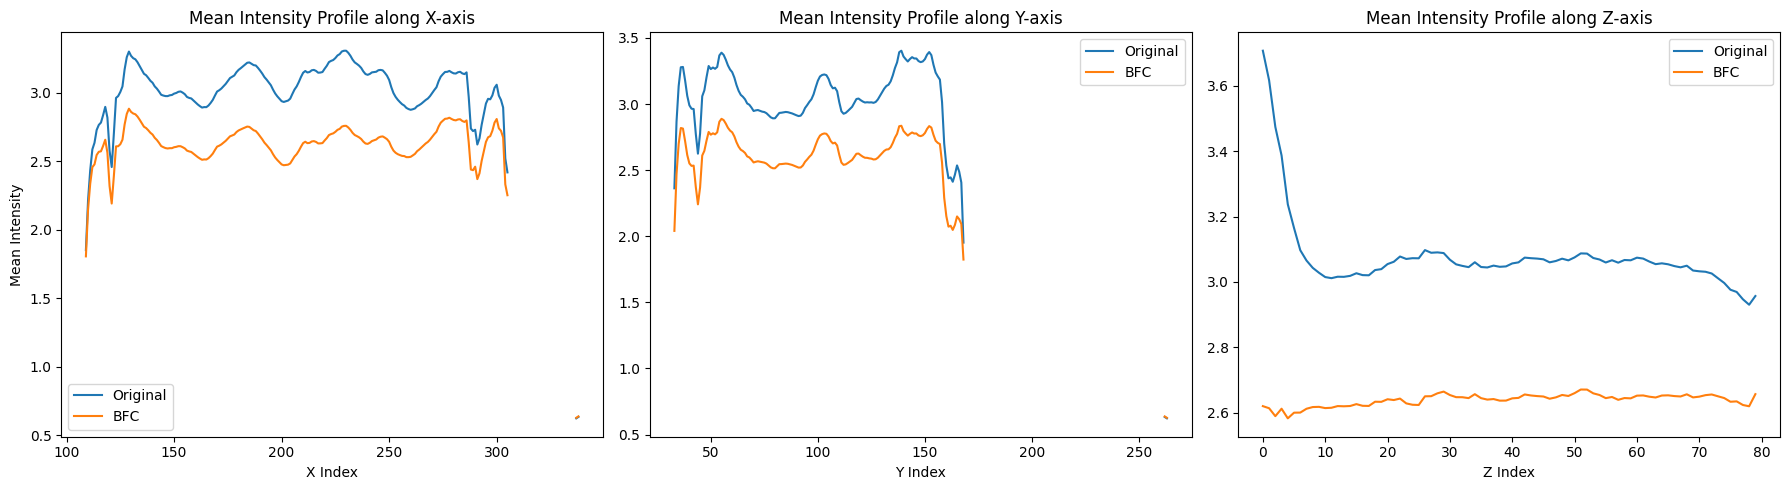

X CoV before: 0.10318733539735774
X CoV after:  0.09174326
Y CoV before: 0.12604639488515307
Y CoV after:  0.11796851


In [5]:
n = 10
data_BFC, affine = load_nifti(file_paths_BFC[n])
data, affine = load_nifti(file_paths[n])
mask = np.load(mask_paths[n], allow_pickle=True)


# Example: compute profiles before and after BFC
mean_x_orig, mean_y_orig, mean_z_orig = compute_axis_profiles(data, mask)
mean_x_bfc, mean_y_bfc, mean_z_bfc = compute_axis_profiles(data_BFC, mask)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(mean_x_orig, label="Original")
axes[0].plot(mean_x_bfc, label="BFC")
axes[0].set_title("Mean Intensity Profile along X-axis")
axes[0].set_xlabel("X Index")
axes[0].set_ylabel("Mean Intensity")
axes[0].legend()

axes[1].plot(mean_y_orig, label="Original")
axes[1].plot(mean_y_bfc, label="BFC")
axes[1].set_title("Mean Intensity Profile along Y-axis")
axes[1].set_xlabel("Y Index")
axes[1].legend()

axes[2].plot(mean_z_orig, label="Original")
axes[2].plot(mean_z_bfc, label="BFC")
axes[2].set_title("Mean Intensity Profile along Z-axis")
axes[2].set_xlabel("Z Index")
axes[2].legend()

plt.tight_layout()
plt.show()



print("X CoV before:", coeff_of_variation(mean_x_orig))
print("X CoV after: ", coeff_of_variation(mean_x_bfc))

print("Y CoV before:", coeff_of_variation(mean_y_orig))
print("Y CoV after: ", coeff_of_variation(mean_y_bfc))

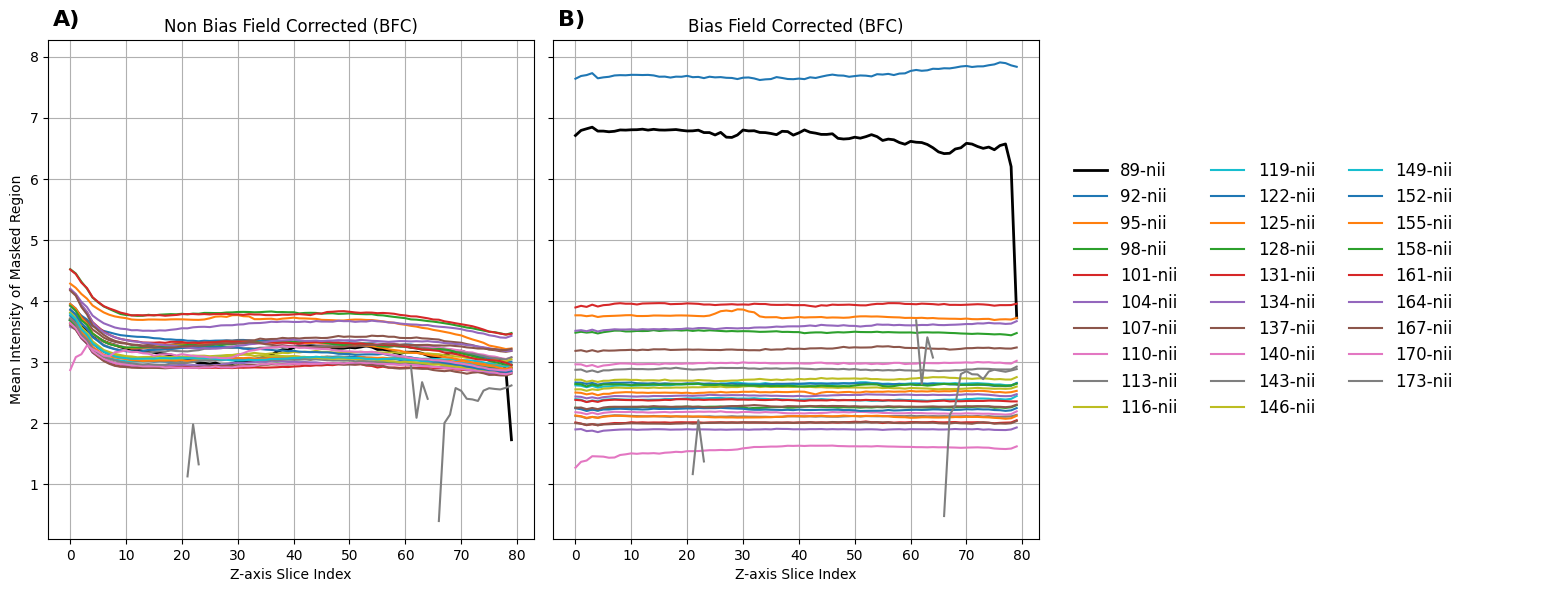

In [17]:
fig = plt.figure(figsize=(16, 6))

# Plot masked means for original data
ax1 = plt.subplot(1, 3, 1)
lines1 = []
labels1 = []
for idx, means in enumerate(all_masked_means):
    id = Path(file_paths[idx]).parent.name
    if idx == 0:
        line, = ax1.plot(means, label=f'{id}', color='black', linewidth=2)
    else:
        line, = ax1.plot(means, label=f'{id}')
    lines1.append(line)
    labels1.append(f'{id}')
ax1.set_xlabel('Z-axis Slice Index')
ax1.set_ylabel('Mean Intensity of Masked Region')
ax1.set_title('Non Bias Field Corrected (BFC)')
ax1.text(0.01, 1.06, "A)", transform=ax1.transAxes,
             fontsize=16, fontweight='bold', va='top')
ax1.grid(True)

# Plot masked means for BFC data
ax2 = plt.subplot(1, 3, 2)
lines2 = []
labels2 = []
for idx, means in enumerate(all_masked_means_BFC):
    id = Path(file_paths_BFC[idx]).parent.name
    if idx == 0:
        line, = ax2.plot(means, label=f'{id}', color='black', linewidth=2)
    else:
        line, = ax2.plot(means, label=f'{id}')
    lines2.append(line)
    labels2.append(f'{id}')
ax2.set_xlabel('Z-axis Slice Index')
ax2.set_title('Bias Field Corrected (BFC)')
ax2.text(0.01, 1.06, "B)", transform=ax2.transAxes,
             fontsize=16, fontweight='bold', va='top')
ax2.grid(True)
# Align y-axis limits of both plots and remove y-tick labels from the second plot
ax1.set_ylim(ax2.get_ylim())
ax2.set_yticklabels([])  # ← This hides tick labels but keeps tick marks

# Legend as its own subplot
ax3 = plt.subplot(1, 3, 3)
ax3.axis('off')
ax3.legend(lines1, labels1, loc='center left', fontsize='large', ncol=3, frameon=False, )

plt.savefig('figures/Masked_Means_Comparison_BFC and Original.svg', dpi=3000, bbox_inches='tight')
plt.tight_layout()
plt.show()




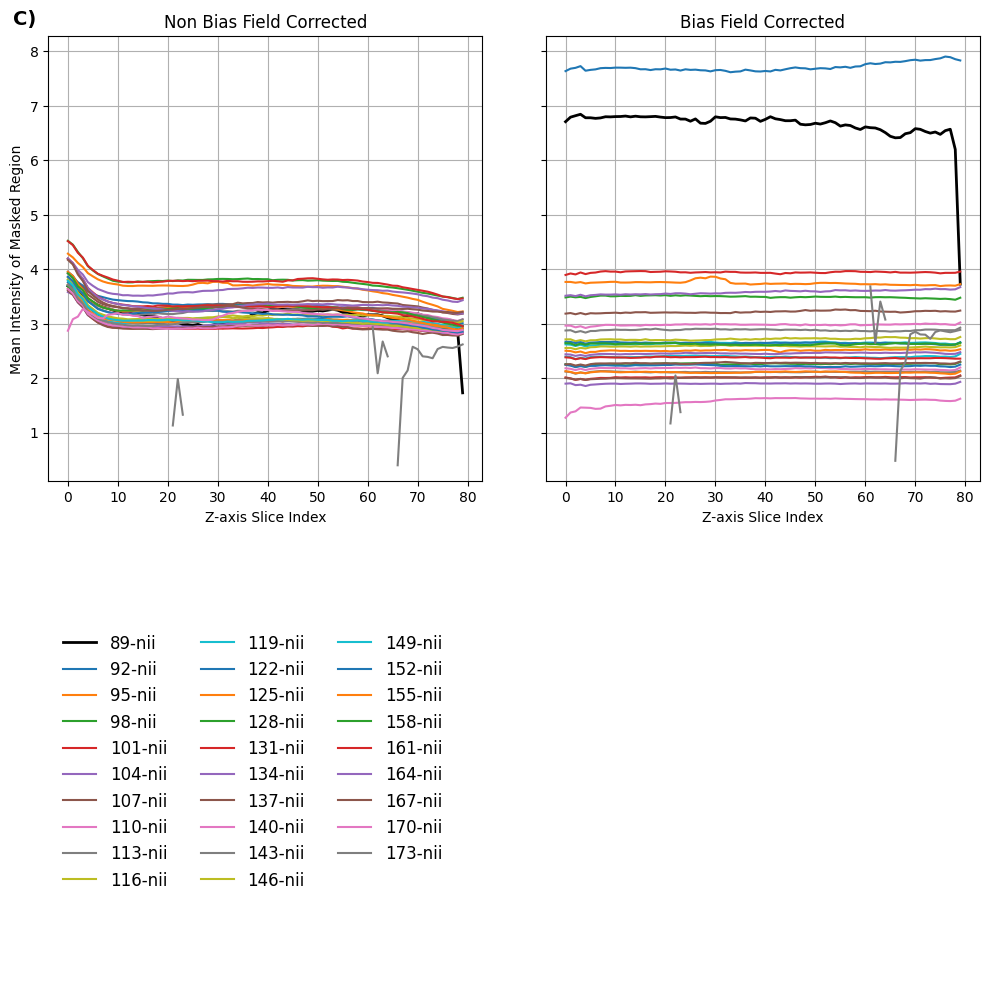

In [16]:
fig = plt.figure(figsize=(10, 10))

# Plot masked means for original data
ax1 = plt.subplot(2, 2, 1)
lines1 = []
labels1 = []
for idx, means in enumerate(all_masked_means):
    id = Path(file_paths[idx]).parent.name
    if idx == 0:
        line, = ax1.plot(means, label=f'{id}', color='black', linewidth=2)
    else:
        line, = ax1.plot(means, label=f'{id}')
    lines1.append(line)
    labels1.append(f'{id}')
ax1.set_xlabel('Z-axis Slice Index')
ax1.set_ylabel('Mean Intensity of Masked Region')
ax1.set_title('Non Bias Field Corrected')
ax1.text(-0.08, 1.06, "C)", transform=ax1.transAxes,
             fontsize=14, fontweight='bold', va='top')
ax1.grid(True)

# Plot masked means for BFC data
ax2 = plt.subplot(2, 2, 2)
lines2 = []
labels2 = []
for idx, means in enumerate(all_masked_means_BFC):
    id = Path(file_paths_BFC[idx]).parent.name
    if idx == 0:
        line, = ax2.plot(means, label=f'{id}', color='black', linewidth=2)
    else:
        line, = ax2.plot(means, label=f'{id}')
    lines2.append(line)
    labels2.append(f'{id}')
ax2.set_xlabel('Z-axis Slice Index')
ax2.set_title('Bias Field Corrected')
#ax2.text(0.01, 1.06, "B)", transform=ax2.transAxes,
#             fontsize=16, fontweight='bold', va='top')
ax2.grid(True)
# Align y-axis limits of both plots and remove y-tick labels from the second plot
ax1.set_ylim(ax2.get_ylim())
ax2.set_yticklabels([])  # ← This hides tick labels but keeps tick marks

# Legend as its own subplot
ax3 = plt.subplot(2, 2, 3)
ax3.axis('off')
ax3.legend(lines1, labels1, loc='center left', fontsize='large', ncol=3, frameon=False, )

plt.savefig('figures/Masked_Means_Comparison_BFC and Original.svg', dpi=3000, bbox_inches='tight')
plt.tight_layout()
plt.show()




# Plot 3 (Bias field correction of combined images)

In [21]:
def evaluate_bias_field_correction(original_image = None, corrected_image = None, bias_field=None, xi = 180 , yi = 180, zi = 40, save_path = None):
    """
    Evaluate the bias field correction by comparing the original and corrected images.
    This function calculates the mean squared error (MSE) and displays both images.
    """
    original_data = original_image.numpy()
    corrected_data = corrected_image.numpy()
    bias_field_data = bias_field.numpy()

    # Calculate the mean squared error (MSE) between the original and corrected images
    mse = np.mean((original_data - corrected_data) ** 2)
    print(f"Mean Squared Error (MSE): {mse:.4f}")

    #### Compute mean intensity along z (slice axis) ####
    original_data = original_image.numpy()
    corrected_data = corrected_image.numpy()

    # Mean intensity along axes
    # Only calculate mean intensity on non-zero voxels for each slice
    mean_intensity_before = [
        original_data[:, :, z][original_data[:, :, z] > 0].mean() if np.any(original_data[:, :, z] > 0) else 0
        for z in range(original_data.shape[2])
    ]
    mean_intensity_after = [
        corrected_data[:, :, z][corrected_data[:, :, z] > 0].mean() if np.any(corrected_data[:, :, z] > 0) else 0
        for z in range(corrected_data.shape[2])
    ]
    mean_intensity_before_x = [
        original_data[x, :, :][original_data[x, :, :] > 0].mean() if np.any(original_data[x, :, :] > 0) else 0
        for x in range(original_data.shape[0])
    ]
    mean_intensity_after_x = [
        corrected_data[x, :, :][corrected_data[x, :, :] > 0].mean() if np.any(corrected_data[x, :, :] > 0) else 0
        for x in range(corrected_data.shape[0])
    ]
    mean_intensity_before_y = [
        original_data[:, y, :][original_data[:, y, :] > 0].mean() if np.any(original_data[:, y, :] > 0) else 0
        for y in range(original_data.shape[1])
    ]
    mean_intensity_after_y = [
        corrected_data[:, y, :][corrected_data[:, y, :] > 0].mean() if np.any(corrected_data[:, y, :] > 0) else 0
        for y in range(corrected_data.shape[1])
    ]


    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    # Figure + GridSpec with a spacer column (index 3)
    fig = plt.figure(figsize=(18, 18))
    gs = gridspec.GridSpec(
        3, 5,
        width_ratios=[1, 1, 1, 0.2, 1],  # col=3 is the spacer (narrow)
        wspace=0.05,                      # inter-column spacing
        hspace=0.2                      # inter-row spacing
    )

    # Row 1 (Coronal + Z-mean plot)
    ax1  = fig.add_subplot(gs[0, 0])
    ax2  = fig.add_subplot(gs[0, 1])
    ax3  = fig.add_subplot(gs[0, 2])
    # gs[0, 3] is the spacer; don't use it
    ax4  = fig.add_subplot(gs[0, 4])

    # Row 2 (Axial + X-mean plot)
    ax5  = fig.add_subplot(gs[1, 0])
    ax6  = fig.add_subplot(gs[1, 1])
    ax7  = fig.add_subplot(gs[1, 2])
    ax8  = fig.add_subplot(gs[1, 4])

    # Row 3 (Sagittal + Y-mean plot)
    ax9  = fig.add_subplot(gs[2, 0])
    ax10 = fig.add_subplot(gs[2, 1])
    ax11 = fig.add_subplot(gs[2, 2])
    ax12 = fig.add_subplot(gs[2, 4])

    ###### Display Xi (Sagittal) ######
    ax1.imshow(original_data[:, xi, :], cmap='gray', aspect='auto')
    ax1.axis("off")
    ax1.text(.45, 1.1, "Original", transform=ax1.transAxes, fontsize=18, fontweight='bold',
            va='top', ha='center')
    ax1.text(-.15, .5, "Sagittal", transform=ax1.transAxes, fontsize=18, fontweight='bold',
            va='center', rotation=90)
    ax1.text(-0.01, 1.1, "A)", transform=ax1.transAxes, fontsize=18, fontweight='bold', va='top')

    ax2.imshow(corrected_data[:, xi, :], cmap='gray', aspect='auto')
    ax2.axis("off")
    ax2.text(.45, 1.1, "Bias Field Corrected", transform=ax2.transAxes, fontsize=18,
            fontweight='bold', va='top', ha='center')

    ax3.imshow(bias_field_data[:, xi, :], cmap='gray', aspect='auto')
    ax3.axis("off")
    ax3.text(.45, 1.1, "Bias Field", transform=ax3.transAxes, fontsize=18, fontweight='bold',
            va='top', ha='center')

    ###### Display zi (Axial) ######
    ax5.imshow(original_data[:, :, zi], cmap='gray', aspect='auto')
    ax5.axis("off")
    ax5.text(-.15, .5, "Axial", transform=ax5.transAxes, fontsize=18, fontweight='bold',
            va='center', rotation=90)

    ax6.imshow(corrected_data[:, :, zi], cmap='gray', aspect='auto')
    ax6.axis("off")

    ax7.imshow(bias_field_data[:, :, zi], cmap='gray', aspect='auto')
    ax7.axis("off")

    ###### Display yi (Coronal) ######
    ax9.imshow(original_data[yi, :, :], cmap='gray', aspect='auto')
    ax9.axis("off")
    ax9.text(-.15, .5, "Coronal", transform=ax9.transAxes, fontsize=18, fontweight='bold',
            va='center', rotation=90)

    ax10.imshow(corrected_data[yi, :, :], cmap='gray', aspect='auto')
    ax10.axis("off")

    ax11.imshow(bias_field_data[yi, :, :], cmap='gray', aspect='auto')
    ax11.axis("off")

    ###### Plots (Z / X / Y mean intensity) ######
    # Z-axis
    ax4.plot(mean_intensity_before, label='Before', linestyle='-')
    ax4.plot(mean_intensity_after,  label='After',  linestyle='-')
    ax4.set_xlabel('Slice (z-axis)')
    ax4.set_ylabel('Mean Intensity')
    ax4.set_title('Mean Intensity (z-axis)')
    ax4.text(-0.01, 1.1, "B)", transform=ax4.transAxes, fontsize=18, fontweight='bold', va='top')
    
    ax4.grid(True)

    # Vertical lines every 70 slices
    for x_ in range(0, len(mean_intensity_before), 70):
        ax4.axvline(x=x_, linestyle=':', color="black", alpha=0.35)

    ax4.axvline(x=0, linestyle=':', color="black", alpha=0.35, label="Slab Boundary")
    ax4.legend()
    
    # X-axis
    ax8.plot(mean_intensity_before_x, label='Before', linestyle='-')
    ax8.plot(mean_intensity_after_x,  label='After',  linestyle='-')
    ax8.set_xlabel('Slice (x-axis)')
    ax8.set_ylabel('Mean Intensity')
    ax8.set_title('Mean Intensity (x-axis)')
    ax8.legend()
    ax8.grid(True)

    # Y-axis
    ax12.plot(mean_intensity_before_y, label='Before', linestyle='-')
    ax12.plot(mean_intensity_after_y,  label='After',  linestyle='-')
    ax12.set_xlabel('Slice (y-axis)')
    ax12.set_ylabel('Mean Intensity')
    ax12.set_title('Mean Intensity (y-axis)')
    ax12.legend()
    ax12.grid(True)

    fig.tight_layout()
    if save_path != None:
        plt.savefig(save_path, dpi=3000, bbox_inches='tight')
    plt.show()
        # Coefficient of variation (CV) across slices

    cv_before = np.std(mean_intensity_before) / np.mean(mean_intensity_before)
    cv_after = np.std(mean_intensity_after) / np.mean(mean_intensity_after)
    print(f"CV before: {cv_before:.4f}, CV after: {cv_after:.4f}")


    # Histogram of intensities before and after correction
    # Flatten and remove zeros
    original_flat = original_data[original_data > 0].flatten()
    corrected_flat = corrected_data[corrected_data > 0].flatten()


    plt.hist(original_flat, bins=100, alpha=0.5, label='Before')
    plt.hist(corrected_flat, bins=100, alpha=0.5, label='After')
    plt.legend()
    plt.title("Histogram of Intensities")


    plt.show()


    
    return mse

In [18]:
data_full_BFC = ants.image_read("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated_BFC_corrected20.nii.gz")
data_full = ants.image_read("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated.nii.gz")

bias_field = ants.image_read("Combined_Data/Rotated and Transposed/bias_field_RARE_combined_20.nii.gz")

mask_full = np.load("Combined_Data/Rotated and Transposed/MASK_RARE_combined_trans_denoised_gibbs_masked_rotated_BFC_corrected20.npy")

Mean Squared Error (MSE): 1.3871


C:\Users\sigur\AppData\Local\Temp\ipykernel_25216\2741603131.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


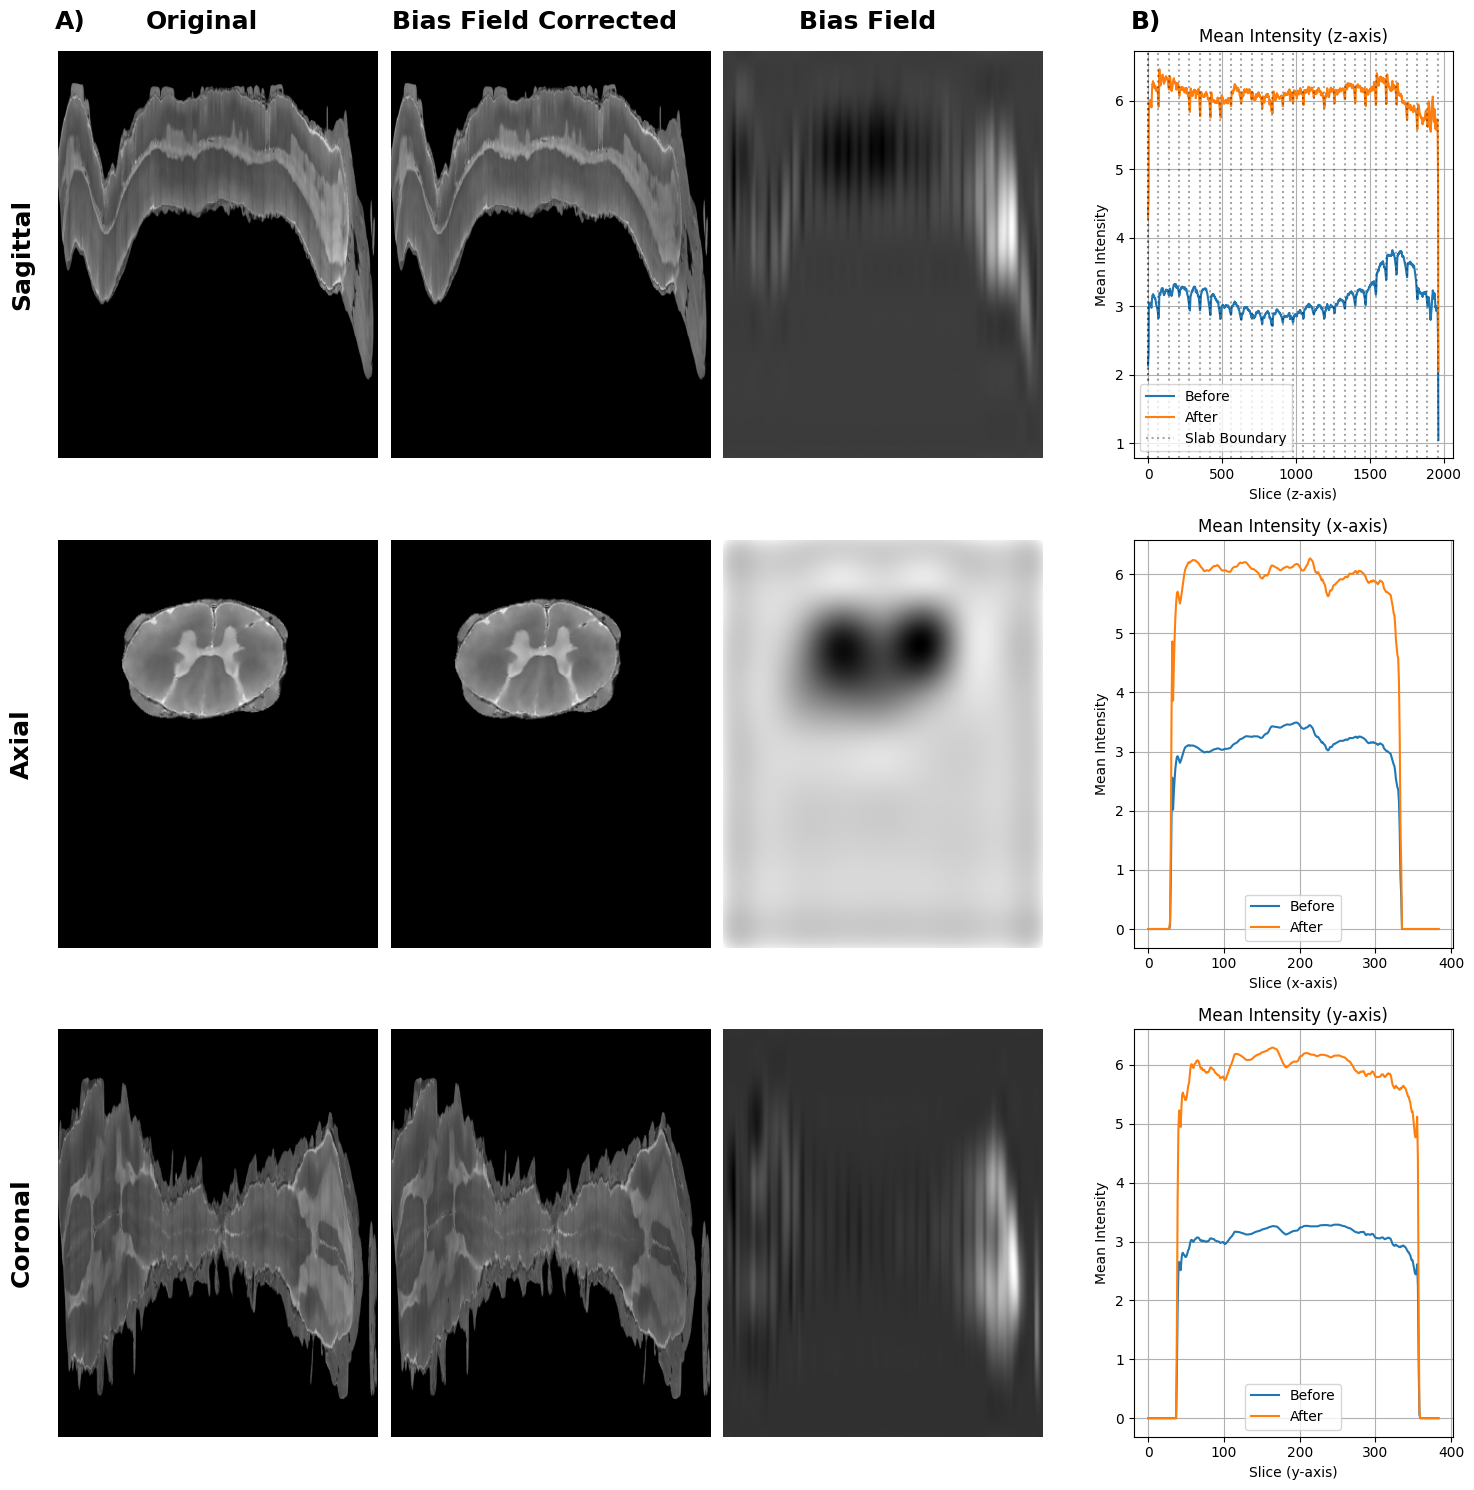

CV before: 0.0831, CV after: 0.0328


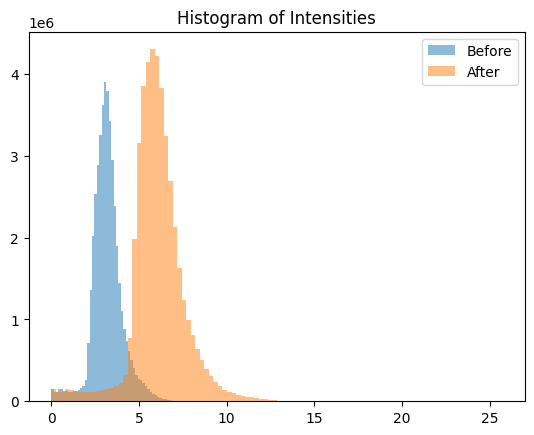

np.float32(1.3870918)

In [ ]:


evaluate_bias_field_correction(original_image = data_full, 
                               corrected_image = data_full_BFC, 
                               bias_field = bias_field, xi = 180, yi = 140, zi = 500,
                               save_path= 'figures/T2_Bias_Field_Correction_Evaluation.svg')

Mean Squared Error (MSE): 1.3871


C:\Users\sigur\AppData\Local\Temp\ipykernel_22720\2741603131.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


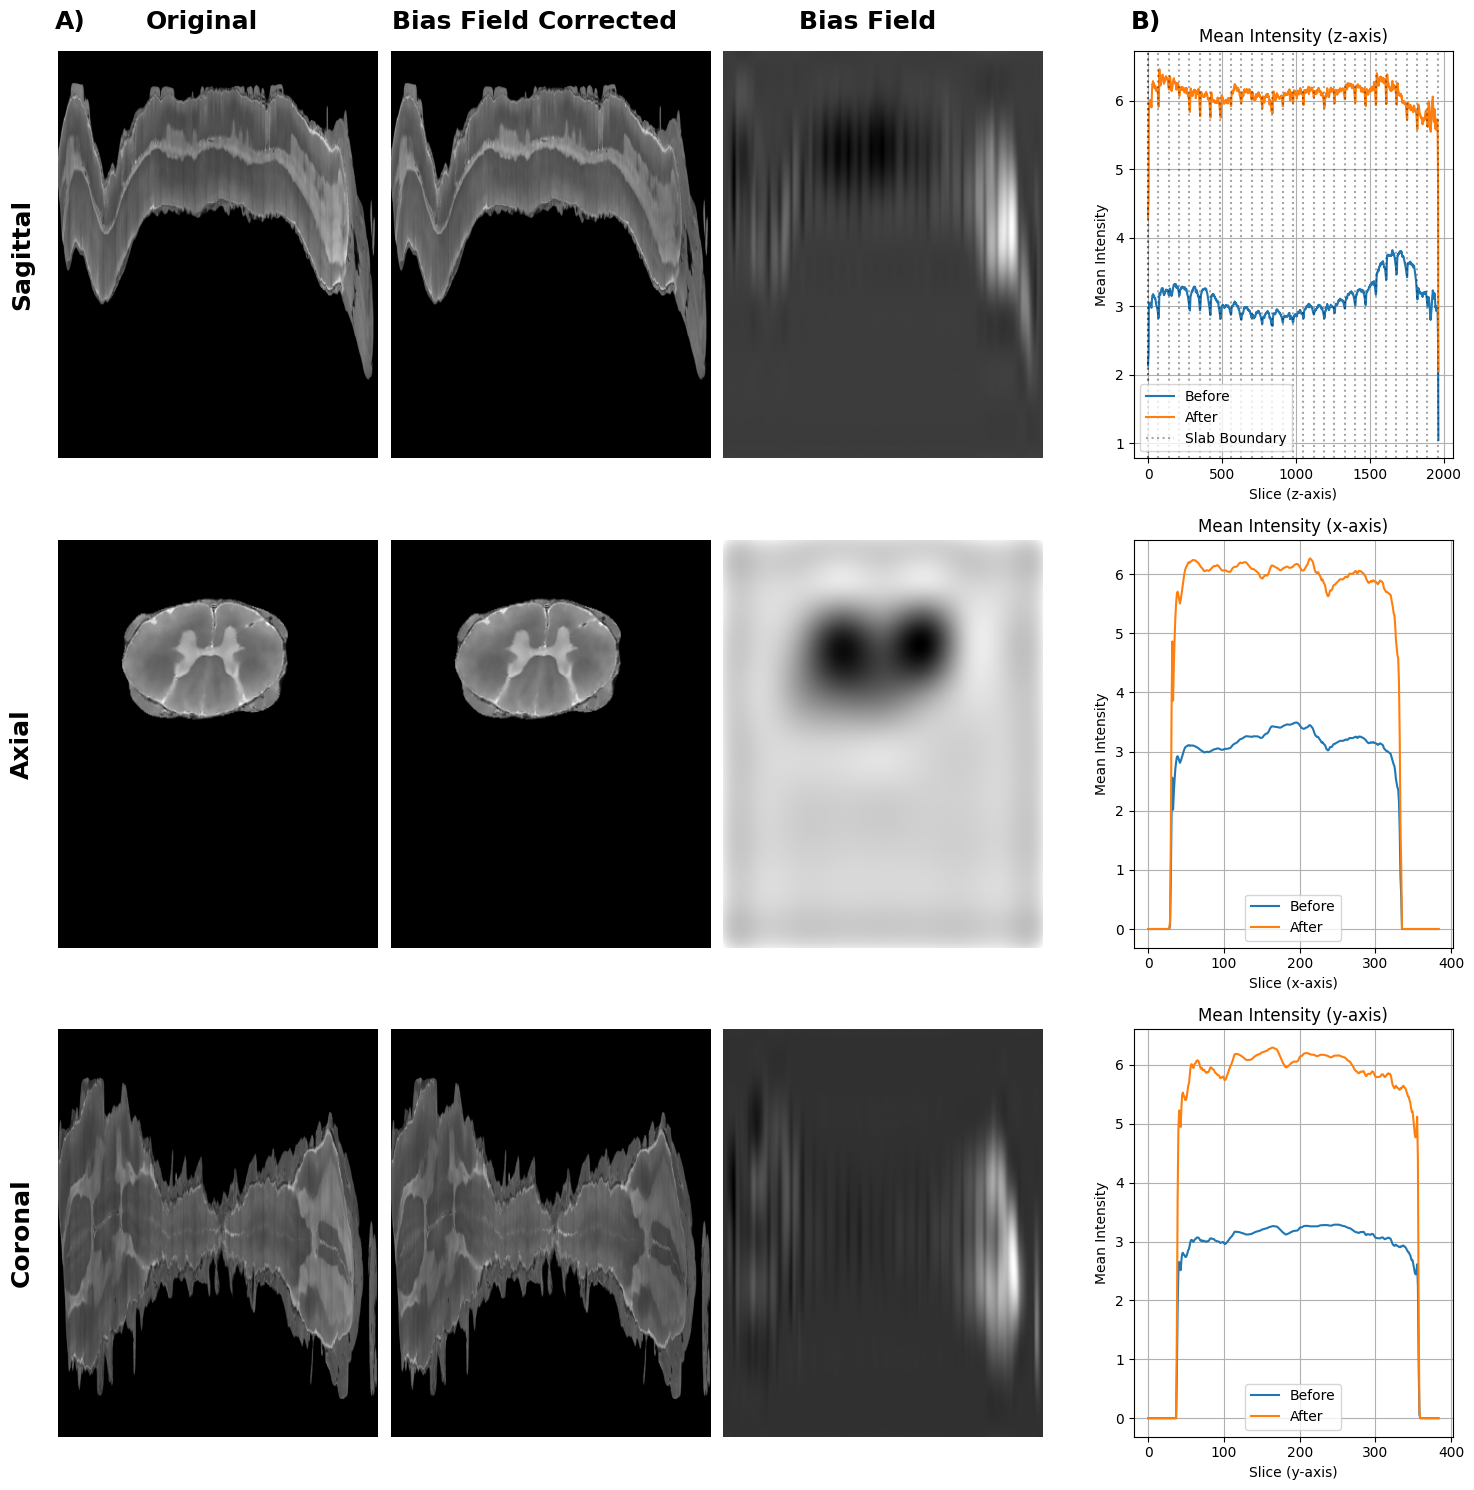

CV before: 0.0831, CV after: 0.0328


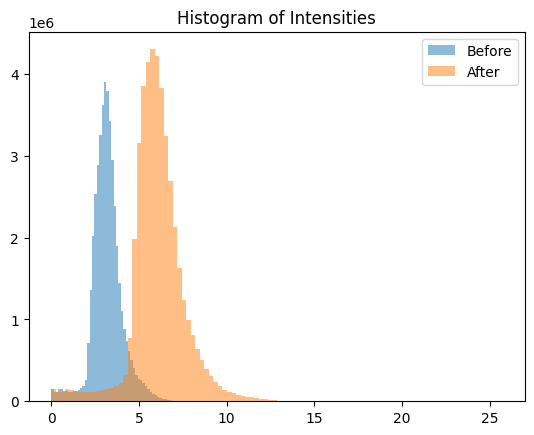

C:\Users\sigur\AppData\Local\Temp\ipykernel_22720\798051640.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


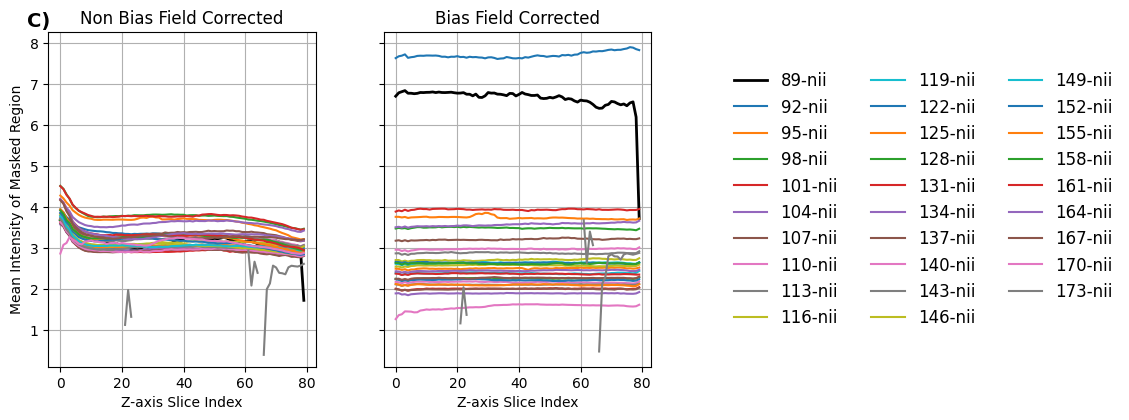

In [23]:
import matplotlib.gridspec as gridspec

# Bottom row: bias field correction evaluation
evaluate_bias_field_correction(
    original_image=data_full,
    corrected_image=data_full_BFC,
    bias_field=bias_field,
    xi=180, yi=140, zi=500,
    save_path=None  # Don't save inside function, just plot
)


fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 5, width_ratios=[1, 1, 1, 0.2, 1], wspace=0.3, hspace=0.3)

# Top row: masked means plots
ax1 = fig.add_subplot(gs[0, 0])
lines1 = []
labels1 = []
for idx, means in enumerate(all_masked_means):
    id = Path(file_paths[idx]).parent.name
    if idx == 0:
        line, = ax1.plot(means, label=f'{id}', color='black', linewidth=2)
    else:
        line, = ax1.plot(means, label=f'{id}')
    lines1.append(line)
    labels1.append(f'{id}')
ax1.set_xlabel('Z-axis Slice Index')
ax1.set_ylabel('Mean Intensity of Masked Region')
ax1.set_title('Non Bias Field Corrected')
ax1.text(-0.08, 1.06, "C)", transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top')
ax1.grid(True)

ax2 = fig.add_subplot(gs[0, 1])
lines2 = []
labels2 = []
for idx, means in enumerate(all_masked_means_BFC):
    id = Path(file_paths_BFC[idx]).parent.name
    if idx == 0:
        line, = ax2.plot(means, label=f'{id}', color='black', linewidth=2)
    else:
        line, = ax2.plot(means, label=f'{id}')
    lines2.append(line)
    labels2.append(f'{id}')
ax2.set_xlabel('Z-axis Slice Index')
ax2.set_title('Bias Field Corrected')
ax2.grid(True)
ax1.set_ylim(ax2.get_ylim())
ax2.set_yticklabels([])

ax3 = fig.add_subplot(gs[0, 2])
ax3.axis('off')
ax3.legend(lines1, labels1, loc='center left', fontsize='large', ncol=3, frameon=False)


plt.tight_layout()
#plt.savefig('figures/Combined_MaskedMeans_and_BiasFieldEval.svg', dpi=600, bbox_inches='tight')
plt.show()


In [28]:
B0_mean = ants.image_read("Combined_Data/Rotated and Transposed/B0_mean.nii.gz")
B0_mean_BFC = ants.image_read("Combined_Data/Rotated and Transposed/B0_BFC_corrected20.nii.gz")
bias_field_b0 = ants.image_read("Combined_Data/Rotated and Transposed/bias_field_dwMRI_b0_combined_20.nii.gz")

Mean Squared Error (MSE): 9.0884


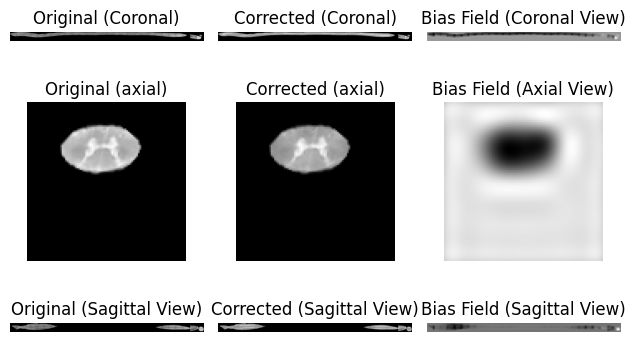

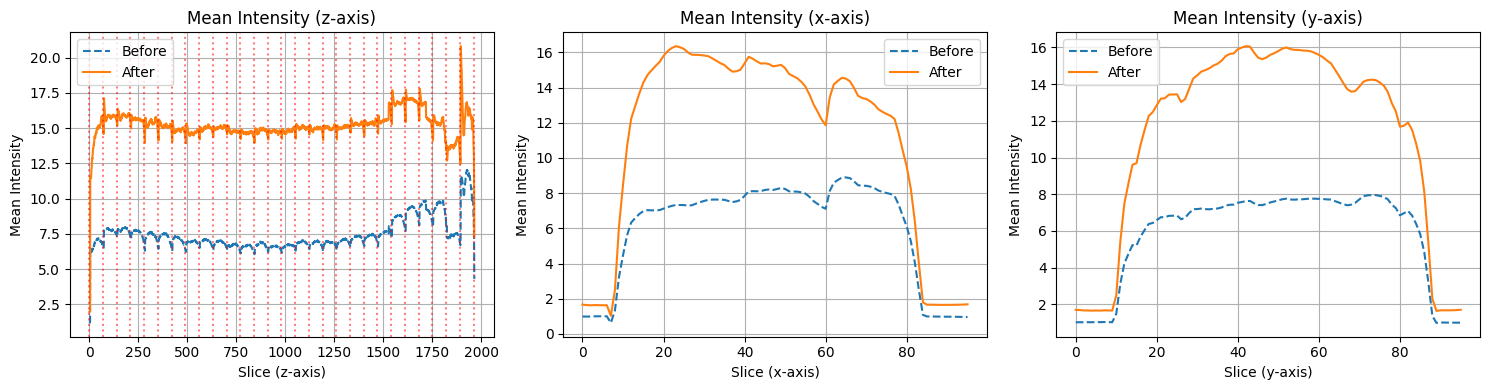

CV before: 0.1509, CV after: 0.0712


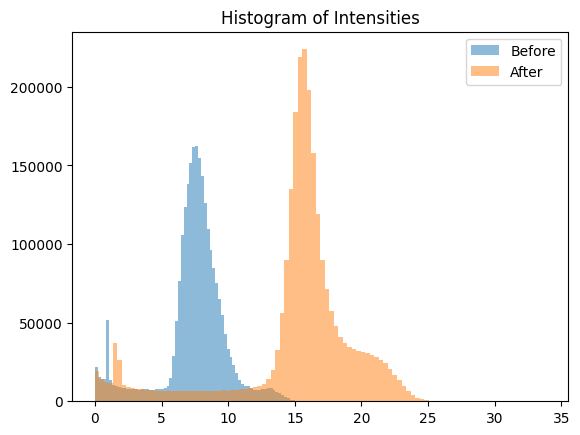

np.float32(9.08836)

In [34]:
evaluate_bias_field_correction(original_image = B0_mean, 
                               corrected_image = B0_mean_BFC, 
                               bias_field = bias_field_b0, xi = 45, yi = 45, zi = 500)

C:\Users\sigur\AppData\Local\Temp\ipykernel_25216\1641135966.py:9: RuntimeWarning: Mean of empty slice
  mean_x = np.nanmean(data, axis=(1, 2))  # mean along y-z plane
C:\Users\sigur\AppData\Local\Temp\ipykernel_25216\1641135966.py:10: RuntimeWarning: Mean of empty slice
  mean_y = np.nanmean(data, axis=(0, 2))  # mean along x-z plane


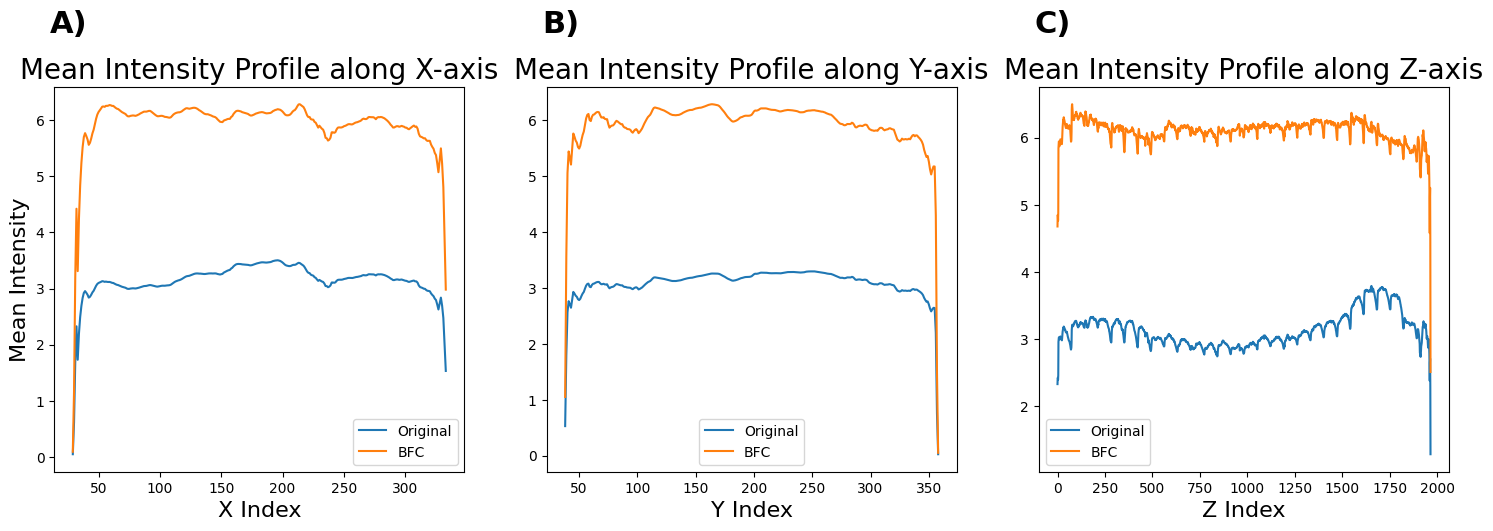

X CoV before: 0.10932292630351984
X CoV after:  0.09940622
Y CoV before: 0.10082314832917005
Y CoV after:  0.096980184


In [19]:
mean_x_orig, mean_y_orig, mean_z_orig = compute_axis_profiles(data_full, mask_full)
mean_x_bfc, mean_y_bfc, mean_z_bfc = compute_axis_profiles(data_full_BFC, mask_full)
#mean_x_orig, mean_y_orig, mean_z_orig = compute_axis_profiles(data_full)
#mean_x_bfc, mean_y_bfc, mean_z_bfc = compute_axis_profiles(data_full_BFC)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(mean_x_orig, label="Original")
axes[0].plot(mean_x_bfc, label="BFC")
axes[0].set_title("Mean Intensity Profile along X-axis", fontsize = 20)
axes[0].set_xlabel("X Index",fontsize = 16)
axes[0].set_ylabel("Mean Intensity",fontsize = 16)
axes[0].text(-0.01, 1.2, "A)", transform=axes[0].transAxes,
             fontsize=22, fontweight='bold', va='top')
axes[0].legend()

axes[1].plot(mean_y_orig, label="Original")
axes[1].plot(mean_y_bfc, label="BFC")
axes[1].set_title("Mean Intensity Profile along Y-axis", fontsize = 20)
axes[1].set_xlabel("Y Index",fontsize = 16)
axes[1].legend()
axes[1].text(-0.01, 1.2, "B)", transform=axes[1].transAxes,
             fontsize=22, fontweight='bold', va='top')

axes[2].plot(mean_z_orig, label="Original")
axes[2].plot(mean_z_bfc, label="BFC")
axes[2].set_title("Mean Intensity Profile along Z-axis", fontsize = 20)
axes[2].set_xlabel("Z Index", fontsize = 16)
axes[2].legend()
axes[2].text(-0.01, 1.2, "C)", transform=axes[2].transAxes,
             fontsize=22, fontweight='bold', va='top')

#plt.tight_layout()
plt.savefig('figures/bias_fields/Mean_Intensity_Profiles_Comparison_BFC_and_Original_ENTIRE_spine.jpeg', dpi=2000, bbox_inches='tight')
plt.show()



def coeff_of_variation(profile):
    return np.nanstd(profile) / np.nanmean(profile)

print("X CoV before:", coeff_of_variation(mean_x_orig))
print("X CoV after: ", coeff_of_variation(mean_x_bfc))

print("Y CoV before:", coeff_of_variation(mean_y_orig))
print("Y CoV after: ", coeff_of_variation(mean_y_bfc))

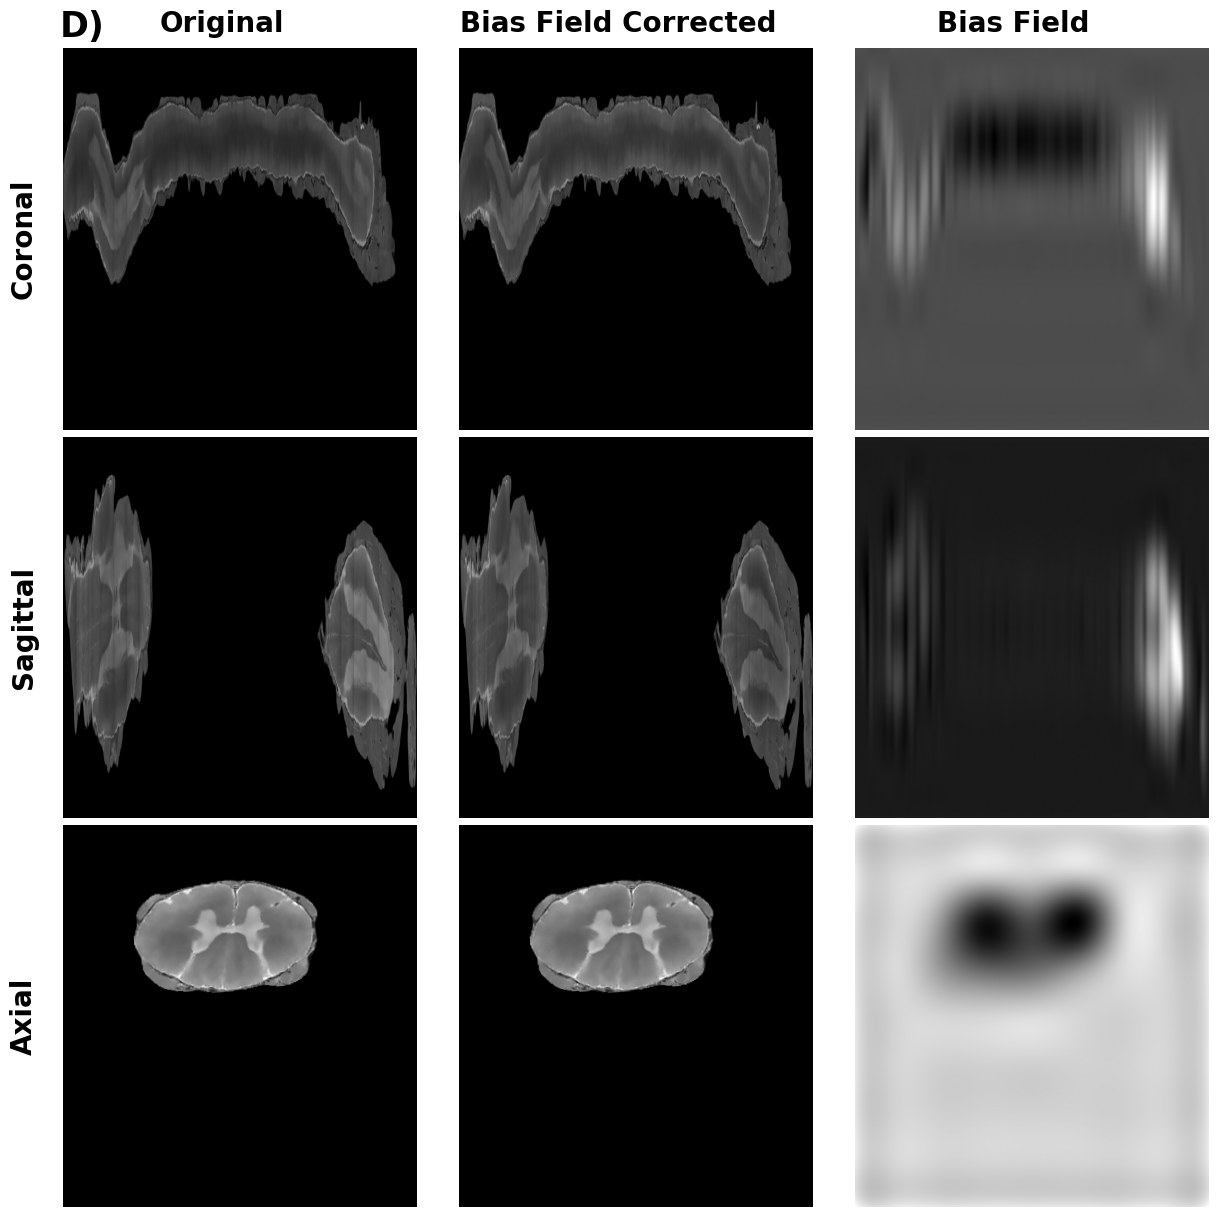

In [16]:
data_full_BFC, affine_full = load_nifti("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated_BFC_corrected20.nii.gz")
data_full, affine_full = load_nifti("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated.nii.gz")

#mask_full = np.load("Combined_Data/Rotated and Transposed/MASK_RARE_combined_trans_denoised_gibbs_masked_rotated_BFC_corrected20.npy")

bias_field , affine  = load_nifti("Combined_Data/Rotated and Transposed/bias_field_RARE_combined_20.nii.gz")

xi = 130
yi = 170
zi = 500
corrected_image = data_full_BFC
original_image = data_full

plt.figure(figsize=(12, 12))
###### Display Xi ######
plt.subplot(3, 3, 1)
plt.imshow(original_image[:, xi, :], cmap='gray', aspect='auto')
#plt.title("Original (Coronal)")
plt.axis("off")
plt.gca().text(.45, 1.1, "Original", transform=plt.gca().transAxes,
               fontsize=20, fontweight='bold', va='top', ha='center')

plt.gca().text(-0.01, 1.1, "D)", transform=plt.gca().transAxes,
               fontsize=25, fontweight='bold', va='top')

plt.gca().text(-.15, .5, "Coronal", transform=plt.gca().transAxes,
               fontsize=20, fontweight='bold', va='center', rotation=90)

plt.subplot(3, 3, 2)
plt.imshow(corrected_image[:, xi, :], cmap='gray', aspect='auto')
#plt.title("Corrected (Coronal)")
plt.axis("off")
plt.gca().text(.45, 1.1, "Bias Field Corrected", transform=plt.gca().transAxes,
               fontsize=20, fontweight='bold', va='top', ha='center')

plt.subplot(3,3,3)
plt.imshow(bias_field[:, xi, :], cmap='gray', aspect='auto')
#plt.title("Bias Field (Coronal View)")
plt.axis("off")
plt.gca().text(.45, 1.1, "Bias Field", transform=plt.gca().transAxes,
               fontsize=20, fontweight='bold', va='top', ha='center')



###### Display yi ######
plt.subplot(3, 3, 4)
plt.imshow(original_image[yi, :], cmap='gray', aspect='auto')
#plt.title("Original (Sagittal View)")
plt.axis("off")
plt.gca().text(-.15, .5, "Sagittal", transform=plt.gca().transAxes,
               fontsize=20, fontweight='bold', va='center', rotation=90)

plt.subplot(3, 3, 5)
plt.imshow(corrected_image[yi, :], cmap='gray', aspect='auto')
#plt.title("Corrected (Sagittal View)")
plt.axis("off")


plt.subplot(3,3,6)
plt.imshow(bias_field[yi,:, :], cmap='gray', aspect='auto')
#plt.title("Original (Sagittal View)")
plt.axis("off")



###### Display zi ######
plt.subplot(3, 3, 7)
plt.imshow(original_image[:, :, zi], cmap='gray', aspect='auto')
#plt.title("Original (axial)")
plt.axis("off")
plt.gca().text(-.15, .5, "Axial", transform=plt.gca().transAxes,
               fontsize=20, fontweight='bold', va='center', rotation=90)

plt.subplot(3, 3, 8)
plt.imshow(corrected_image[:, :, zi], cmap='gray', aspect='auto')
#plt.title("Corrected (axial)")
plt.axis("off")

plt.subplot(3,3,9)
plt.imshow(bias_field[:, :, zi], cmap='gray', aspect='auto')
#plt.title("Bias Field (Axial View)")
plt.axis("off")

#plt.suptitle("Bias Field Correction Across Coronal, Sagittal, and Axial Views", 
#             fontsize=, fontweight='bold', y=1.02)

plt.tight_layout(pad=.5)
plt.savefig('figures/bias_fields/Bias_Field_Correction_Comparison.svg', dpi=1000, bbox_inches='tight')
plt.show()

# Plot 4 (CNN Training)

In [6]:
import svgutils.transform as sg
import sys 

#create new SVG figure
fig = sg.SVGFigure("10cm", "10cm")


path1 = "figures/CNN_training_validation_metrics_GM.svg"
path2 = "figures/CNN_training_validation_metrics_WM.svg"



# load matpotlib-generated figures
fig1 = sg.fromfile(path1)
fig2 = sg.fromfile(path2)

# get the plot objects
plot1 = fig1.getroot()
plot2 = fig2.getroot()

plot1.moveto(0, 0, scale_x= 0.75, scale_y=0.75)
plot2.moveto(0, 600*0.75, scale_x= 0.75, scale_y=0.75)


# add text labels
#txt1 = sg.TextElement(25,20, "A", size=12, weight="bold")
#txt2 = sg.TextElement(600,25, "C)", size=20, weight="bold")

# append plots and labels to figure
fig.append([plot1, plot2])
#fig.append([txt2])
# fig.append([txt1, txt2])

fig.save("figures/CNN_training_validation_metrics_combined_figure.svg")

# Plot 5 (Napari Plot of Spinal cord and mask)

In [9]:
# Mask
gm_wm_mask_path ='Combined_Data/Rotated and Transposed/Combined_GM_WM_mask_aug_rotated_FINAL_f1_threshold_dilated_GM_96x96.npy'
mask_gm_wm = np.load(gm_wm_mask_path).squeeze()
mask_gm_wm = np.transpose(mask_gm_wm, (2, 1, 0))
mask_gm_wm = np.flip(mask_gm_wm, axis=0)

# DTI DATA 
DTI_combined_preproc_trans_masked_rotated , DTI_Affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz")
DTI_combined_preproc_trans_masked_rotated.shape

(96, 96, 1965, 83)

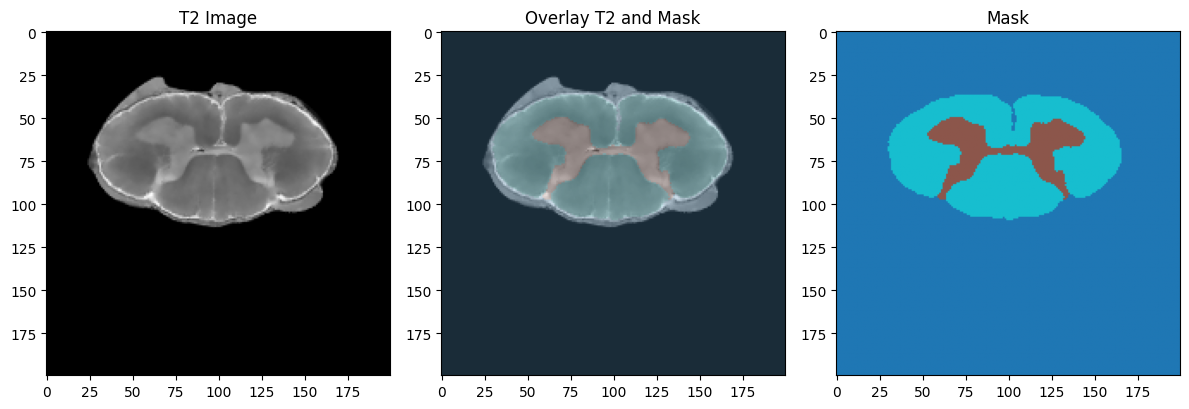

In [ ]:

RARE_200 = np.load("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_BFC_200_200.npy")
#RARE_200 = np.load("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_200_200.npy")
RARE_200 = RARE_200.squeeze()
RARE_200 = np.transpose(RARE_200, (1,2, 0))
#RARE_200 = np.flip(RARE_200, axis=0)

combined_mask = np.load("Combined_Data/Rotated and Transposed/Combined_GM_WM_mask_aug_rotated_FINAL_f1_threshold_dilated_GM.npy")
mask_gm_wm = combined_mask.squeeze()
mask_gm_wm = np.transpose(mask_gm_wm, (2, 1, 0))
mask_gm_wm = np.flip(mask_gm_wm, axis=0)


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 3)
plt.imshow(mask_gm_wm[:, :, 200], cmap='tab10', vmin=0, vmax=2)  # blue-white-red for mask
plt.title("Mask")

plt.subplot(1, 3, 1)
plt.imshow(RARE_200[:, :, 200], cmap='gray')
plt.title("T2 Image")

plt.subplot(1, 3, 2)
plt.imshow(RARE_200[:, :, 200], cmap='gray', alpha=0.9)
plt.imshow(mask_gm_wm[:, :, 200], cmap='tab10', alpha=0.2, vmin=0, vmax=2)  # overlay with blue/red
plt.title("Overlay T2 and Mask")
plt.tight_layout()
plt.savefig('figures/Mask_T2_post_training_Overlay.png', dpi=800, bbox_inches='tight')

plt.show()

In [ ]:
import napari

# Launch napari
viewer = napari.Viewer(ndisplay=3)  # Start in 3D mode
viewer.add_image(RARE_200[:,:,:-500], name="T2", rendering='mip')


labels = mask_gm_wm.astype(np.int32)  # ensure integer type
layer = viewer.add_labels(labels[:,:,:-500], name='Segmentation', opacity=0.5)

# Optional: custom colors for label ids
layer.color = {
    0: 'transparent',
    1: 'lime',   # class 1
    2: 'magenta' # class 2
}

# Optional niceties
layer.blending = 'translucent'
layer.contour = 1.5          # draw class borders
# viewer.screenshot('overlay.png', canvas_only=True)
napari.run()

# Optional: adjust camera
viewer.camera.angles = (30, 45, 0)  # (elevation, azimuth, roll)
viewer.camera.zoom = 2.0            # Zoom in

# Save a screenshot
viewer.screenshot('figures/3d_volume_render.png', canvas_only=True)

# Plot 6 FA ~ ODI plot

In [2]:
import matplotlib.patches as mpatches

segment_info = {
    "C1":  {"pct": 1.6, "cum_pct": 1.6},
    "C2":  {"pct": 2.2, "cum_pct": 3.9},
    "C3":  {"pct": 3.5, "cum_pct": 7.3},
    "C4":  {"pct": 3.5, "cum_pct": 10.8},
    "C5":  {"pct": 3.5, "cum_pct": 14.3},
    "C6":  {"pct": 3.3, "cum_pct": 17.6},
    "C7":  {"pct": 3.2, "cum_pct": 20.8},
    "C8":  {"pct": 3.4, "cum_pct": 24.1},
    "T1":  {"pct": 3.6, "cum_pct": 27.7},
    "T2":  {"pct": 3.9, "cum_pct": 31.6},
    "T3":  {"pct": 4.4, "cum_pct": 36.0},
    "T4":  {"pct": 5.0, "cum_pct": 41.0},
    "T5":  {"pct": 5.1, "cum_pct": 46.1},
    "T6":  {"pct": 5.6, "cum_pct": 51.8},
    "T7":  {"pct": 5.6, "cum_pct": 57.4},
    "T8":  {"pct": 5.4, "cum_pct": 62.7},
    "T9":  {"pct": 5.1, "cum_pct": 67.8},
    "T10": {"pct": 4.7, "cum_pct": 72.4},
    "T11": {"pct": 4.3, "cum_pct": 76.7},
    "T12": {"pct": 3.9, "cum_pct": 80.6},
    "L1":  {"pct": 3.6, "cum_pct": 84.2},
    "L2":  {"pct": 2.8, "cum_pct": 87.0},
    "L3":  {"pct": 2.4, "cum_pct": 89.4},
    "L4":  {"pct": 2.2, "cum_pct": 91.6},
    "L5":  {"pct": 1.7, "cum_pct": 93.3},
    "S1":  {"pct": 1.5, "cum_pct": 94.9},
    "S2":  {"pct": 1.6, "cum_pct": 96.4},
    "S3":  {"pct": 1.4, "cum_pct": 97.8},
    "S4":  {"pct": 1.3, "cum_pct": 99.1},
    "S5":  {"pct": 0.9, "cum_pct": 100.0},
}
segment_cum_pct = {
    "C1": 1.6, "C2": 3.9, "C3": 7.3, "C4": 10.8, "C5": 14.3, "C6": 17.6, "C7": 20.8, "C8": 24.1,
    "T1": 27.7, "T2": 31.6, "T3": 36.0, "T4": 41.0, "T5": 46.1, "T6": 51.8, "T7": 57.4, "T8": 62.7,
    "T9": 67.8, "T10": 72.4, "T11": 76.7, "T12": 80.6,
    "L1": 84.2, "L2": 87.0, "L3": 89.4, "L4": 91.6, "L5": 93.3,
    "S1": 94.9, "S2": 96.4, "S3": 97.8, "S4": 99.1, "S5": 100.0,
}

min_z = 10
max_z = -150

#t2, affine_t2 = load_nifti("Combined_data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated_BFC_corrected20.nii.gz")
#t2 = t2[:,:,min_z:max_z]

t2_trans_in_b0_space, affine_t2_trans_in_b0_space  = load_nifti("Combined_Data/Transposed/T2_in_DWI.nii.gz")
t2_trans_in_b0_space = t2_trans_in_b0_space[:,:,min_z:max_z]

t2_trans, affine_t2_trans = load_nifti("Combined_Data/Transposed/RARE_combined_trans_denoised_gibbs_masked_BFC_corrected20.nii.gz")
t2_trans = t2_trans[:,:,min_z:max_z]

# Calculate actual z-index for all spinal segments using cum_pct and t2 z-dimension
z_dim = t2_trans.shape[2]
segment_z_index = {}

for seg, info in segment_info.items():
    cum_pct = info["cum_pct"]
    z_idx = int(round((cum_pct / 100) * (z_dim - 1)))
    segment_z_index[seg] = z_idx

print(segment_z_index)

rotation_data = np.load("Combined_data/complete_coordinates_of_lines_for_rotation.pkl", allow_pickle=True)
rotated_angles = rotation_data["smoothed_angle"][min_z:max_z]

{'C1': 29, 'C2': 70, 'C3': 132, 'C4': 195, 'C5': 258, 'C6': 318, 'C7': 375, 'C8': 435, 'T1': 500, 'T2': 570, 'T3': 649, 'T4': 740, 'T5': 832, 'T6': 934, 'T7': 1035, 'T8': 1131, 'T9': 1223, 'T10': 1306, 'T11': 1384, 'T12': 1454, 'L1': 1519, 'L2': 1569, 'L3': 1613, 'L4': 1652, 'L5': 1683, 'S1': 1712, 'S2': 1739, 'S3': 1764, 'S4': 1788, 'S5': 1804}


In [4]:
from skimage.metrics import normalized_mutual_information as nmi

nmi_values = []
for i in range(t2_trans.shape[2] - 1):
    slice1 = t2_trans[:, :, i]
    slice2 = t2_trans[:, :, i + 1]
    nmi_val = nmi(slice1, slice2)
    nmi_values.append(nmi_val)
nmi_values = np.array(nmi_values)

In [6]:
nmi_values.mean()

np.float64(1.5130964927055022)

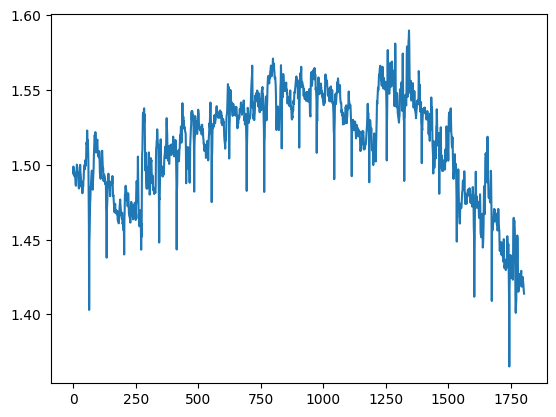

In [5]:
plt.plot(nmi_values)

In [14]:
plot_idx_dict ={"C4": 238,
 "T6": 945,
 "L2": 1560,
 "S3": 1742}

mask = np.load('Combined_Data/Transposed/Combined_GM_WM_mask_aug_FINAL_f1_threshold_dilated_96x96.npy')
mask = np.transpose(mask, (2, 1, 0))
mask = np.flip(mask, axis=0)
mask = mask[:,:,10:-150]

mask_gm_OG = (mask == 1)
mask_wm_OG = (mask == 2)

dti_fit = np.load("Results/tenfit_transposed_BFC20.npy", allow_pickle= True).item()

ODI_NODDI, affine = load_nifti("AMICO/NODDI_TRANS_wm_gm_mask/fit_ODI.nii.gz")
NDI_NODDI, _ = load_nifti("AMICO/NODDI_TRANS_wm_gm_mask/fit_NDI.nii.gz")
FWF_NODDI, _ = load_nifti("AMICO/NODDI_TRANS_wm_gm_mask/fit_FWF.nii.gz")
dir_NODDI,_ = load_nifti("AMICO/NODDI_TRANS_wm_gm_mask/fit_DIR.nii.gz")

NDI_NODDI = NDI_NODDI[:,:,10:-150]
ODI_NODDI = ODI_NODDI[:,:,10:-150]
FWF_NODDI = FWF_NODDI[:,:,10:-150]
dir_NODDI = dir_NODDI[:,:,10:-150]

##### COompute flask and masked array of parameters of interest ###
fa_flat = dti_fit.fa.flatten()
odi_flat = ODI_NODDI.flatten()
mask_flat = mask.flatten()
ndi_flat = NDI_NODDI.flatten()

# Only plot where mask > 0 (GM or WM)
valid = mask_flat > 0
fa_valid = fa_flat[valid]
odi_valid = odi_flat[valid]
mask_valid = mask_flat[valid]
ndi_valid = ndi_flat[valid]


# Only plot where mask == 1 (GM)
valid = mask_flat == 1
fa_gm = fa_flat[valid]
odi_gm = odi_flat[valid]
mask_gm = mask_flat[valid]
ndi_gm = ndi_flat[valid]


# Only plot where mask == 2 ( WM)
valid = mask_flat == 2
fa_wm = fa_flat[valid]
odi_wm = odi_flat[valid]
mask_wm = mask_flat[valid]
ndi_wm = ndi_flat[valid]


# Define colors: 1=GM (red), 2=WM (blue)
colors = np.where(mask_valid == 1, 'red', 'blue')

In [9]:
import pandas as pd

# First, create a reverse mapping from z-index to segment label
z_to_segment = np.empty(ODI_NODDI.shape[2], dtype=object)
sorted_segments = sorted(segment_z_index.items(), key=lambda x: x[1])
for i, (seg, z_idx) in enumerate(sorted_segments):
    start = sorted_segments[i-1][1]+1 if i > 0 else 0
    end = z_idx
    z_to_segment[start:end+1] = seg


# Assign tissue type: 1=GM, 2=WM, 0=other
tissue_type = []
segment_label = []

# z_to_segment is already available and maps z-index to segment label
shape = mask.shape
for idx in range(mask_flat.shape[0]):
    z = idx % shape[2]
    if mask_flat[idx] == 1:
        tissue_type.append('GM')
        segment_label.append(z_to_segment[z])
    elif mask_flat[idx] == 2:
        tissue_type.append('WM')
        segment_label.append(z_to_segment[z])
    else:
        tissue_type.append('Background')
        segment_label.append(None)

df_voxels = pd.DataFrame({
    'ODI': odi_flat,
    'FA': fa_flat,
    'Tissue': tissue_type,
    'Segment': segment_label
})

print(df_voxels.head())

## Remove background voxels from DF
df_no_background = df_voxels[df_voxels['Tissue'] != 'Background'].copy()
print(df_no_background.head())
print(f"Original shape: {df_voxels.shape}, After removing background: {df_no_background.shape}")

   ODI   FA      Tissue Segment
0  0.0  0.0  Background    None
1  0.0  0.0  Background    None
2  0.0  0.0  Background    None
3  0.0  0.0  Background    None
4  0.0  0.0  Background    None
         ODI   FA Tissue Segment
1639863  1.0  0.0     WM      T6
1639864  1.0  0.0     WM      T6
1639874  1.0  0.0     WM      T6
1639875  1.0  0.0     WM      T7
1639878  1.0  0.0     WM      T7
Original shape: (16634880, 4), After removing background: (1760868, 4)


## Regression Models

In [7]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm


# Prepare DataFrame for modeling
# Encode categorical variables
df_no_background['Tissue'] = df_no_background['Tissue'].astype('category')
df_no_background['Segment'] = df_no_background['Segment'].astype('category')

# Log-transform ODI for linearization of exponential decay: ODI = a * exp(-b * FA) + c
# We'll use a nonlinear mixed effects model, but statsmodels does not support this directly.
# Instead, fit per group, or use a linear approximation for illustration:
df_no_background['log_ODI'] = np.log(df_no_background['ODI'] + 1e-10)  # add epsilon to avoid log(0)
df_no_background['log_FA'] = np.log(df_no_background['FA'] + 1e-10)  # add epsilon to avoid log(0)
df_no_background['FA_squared'] = df_no_background['FA'] ** 2

# Linear model with interaction (approximation): log(ODI) ~ FA * Tissue * Segment

model = smf.ols('log_FA ~ ODI * Tissue * Segment', data=df_no_background).fit()

model_mixed_effect_1 = mixedlm('log_FA ~ ODI', df_no_background, groups=df_no_background['Segment']).fit()
model_mixed_effect_2 = mixedlm('log_FA ~ ODI + Tissue', df_no_background, groups=df_no_background['Segment']).fit()
model_mixed_effect_3 = mixedlm('log_FA ~ ODI + Tissue + Segment', df_no_background, groups=df_no_background['Segment']).fit()

model_mixed_effect_4 = mixedlm('log_FA ~ ODI * Tissue + Segment', df_no_background, groups=df_no_background['Segment']).fit()
model_mixed_effect_5 = mixedlm('log_FA ~ ODI * Segment + Tissue', df_no_background, groups=df_no_background['Segment']).fit()
model_mixed_effect_6 = mixedlm('log_FA ~ ODI * Tissue * Segment', df_no_background, groups=df_no_background['Segment']).fit()

print(model.summary())




c:\Users\sigur\miniconda3\envs\DIPY\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sigur\miniconda3\envs\DIPY\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\sigur\miniconda3\envs\DIPY\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sigur\miniconda3\envs\DIPY\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sigur\miniconda3\envs\DIPY\Lib\site-packages\statsmodels\regression\mixed_linear_m

                            OLS Regression Results                            
Dep. Variable:                 log_FA   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                 1.811e+04
Date:                Sat, 30 Aug 2025   Prob (F-statistic):               0.00
Time:                        14:34:30   Log-Likelihood:            -2.9983e+06
No. Observations:             1760868   AIC:                         5.997e+06
Df Residuals:                 1760748   BIC:                         5.998e+06
Df Model:                         119                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [8]:
# Compare mixed effects models using AIC and BIC
model_list = [
    ("Mixed Effect 1: log_FA ~ ODI (Segment random)", model_mixed_effect_1),
    ("Mixed Effect 2: log_FA ~ ODI + Tissue (Segment random)", model_mixed_effect_2),
    ("Mixed Effect 3: log_FA ~ ODI + Tissue + Segment (Segment random)", model_mixed_effect_3),
    ("Mixed Effect 4: log_FA ~ ODI * Tissue + Segment (Segment random)", model_mixed_effect_4),
    ("Mixed Effect 5: log_FA ~ ODI * Segment + Tissue (Segment random)", model_mixed_effect_5),
    ("Mixed Effect 6: log_FA ~ ODI * Tissue * Segment (Segment random)", model_mixed_effect_6),
]

print("Model Comparison (AIC, BIC):")
for name, model in model_list:
    print(f"{name}: AIC={model.aic:.2f}, BIC={model.bic:.2f}")

Model Comparison (AIC, BIC):
Mixed Effect 1: log_FA ~ ODI (Segment random): AIC=nan, BIC=nan
Mixed Effect 2: log_FA ~ ODI + Tissue (Segment random): AIC=nan, BIC=nan
Mixed Effect 3: log_FA ~ ODI + Tissue + Segment (Segment random): AIC=nan, BIC=nan
Mixed Effect 4: log_FA ~ ODI * Tissue + Segment (Segment random): AIC=nan, BIC=nan
Mixed Effect 5: log_FA ~ ODI * Segment + Tissue (Segment random): AIC=nan, BIC=nan
Mixed Effect 6: log_FA ~ ODI * Tissue * Segment (Segment random): AIC=nan, BIC=nan


In [9]:
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2

# Compare mixed effects models using ANOVA (likelihood ratio test)
# Only nested models can be compared directly; here, compare sequentially

print("ANOVA Model Comparison (Likelihood Ratio Test):")
for i in range(1, len(model_list)):
    name_prev, model_prev = model_list[i-1]
    name_curr, model_curr = model_list[i]
    lr_stat = 2 * (model_curr.llf - model_prev.llf)
    df_diff = model_curr.df_modelwc - model_prev.df_modelwc
    p_value = chi2.sf(lr_stat, df_diff)
    print(f"{name_prev} vs {name_curr}: LR stat={lr_stat:.2f}, df diff={df_diff}, p={p_value:.4g}")


ANOVA Model Comparison (Likelihood Ratio Test):
Mixed Effect 1: log_FA ~ ODI (Segment random) vs Mixed Effect 2: log_FA ~ ODI + Tissue (Segment random): LR stat=148749.65, df diff=1, p=0
Mixed Effect 2: log_FA ~ ODI + Tissue (Segment random) vs Mixed Effect 3: log_FA ~ ODI + Tissue + Segment (Segment random): LR stat=38.82, df diff=29, p=0.1052
Mixed Effect 3: log_FA ~ ODI + Tissue + Segment (Segment random) vs Mixed Effect 4: log_FA ~ ODI * Tissue + Segment (Segment random): LR stat=183138.36, df diff=1, p=0
Mixed Effect 4: log_FA ~ ODI * Tissue + Segment (Segment random) vs Mixed Effect 5: log_FA ~ ODI * Segment + Tissue (Segment random): LR stat=71746.46, df diff=28, p=0
Mixed Effect 5: log_FA ~ ODI * Segment + Tissue (Segment random) vs Mixed Effect 6: log_FA ~ ODI * Tissue * Segment (Segment random): LR stat=202706.98, df diff=59, p=0


In [10]:
final_model_sum = model_mixed_effect_6.summary()

In [26]:
print(final_model_sum)

                    Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       log_FA       
No. Observations:        1760868       Method:                   REML         
No. Groups:              30            Scale:                    1.7641       
Min. group size:         4849          Log-Likelihood:           -2998592.3525
Max. group size:         105508        Converged:                Yes          
Mean group size:         58695.6                                              
------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------
Intercept                         0.480    1.339   0.358 0.720  -2.145   3.105
Tissue[T.WM]                      6.499    0.176  36.957 0.000   6.154   6.843
Segment[T.C2]                    -0.037    1.888  -0.020 0.984  -3.738   

In [23]:
final_model_sum_html = final_model_sum.as_html()
with open("Results/final_model_summary.html", "w") as f:
    f.write(final_model_sum_html)

In [24]:
summary_df = pd.DataFrame(model_mixed_effect_6.summary().tables[1])
summary_df.columns = summary_df.iloc[0]
summary_df = summary_df[1:].reset_index(drop=True)
summary_df.__len__()

120

In [ ]:
import pandas as pd
from io import StringIO

# PASTE your entire coefficient table here
data = """Coef\tStd.Err.\tz\tP>|z|\t[0.025\t0.975]
Intercept\t0.480\t1.339\t0.358\t0.720\t-2.145\t3.105
Tissue[T.WM]\t6.499\t0.176\t36.957\t0.000\t6.154\t6.843
Segment[T.C2]\t-0.037\t1.888\t-0.020\t0.984\t-3.738\t3.663
"""

# Read into dataframe
df = pd.read_csv(StringIO(data), sep="\t", header=0)
df.columns = ["Coefficient", "Estimate", "StdErr", "z_value", "p_value", "CI_2.5", "CI_97.5"]

# Format with bold for significant p-values
def format_row(row):
    bold = row['p_value'] < 0.05
    def fmt(val): return f"**{val:.3f}**" if bold else f"{val:.3f}"
    return [
        f"**{row['Coefficient']}**" if bold else row['Coefficient'],
        fmt(row['Estimate']),
        fmt(row['StdErr']),
        fmt(row['z_value']),
        fmt(row['p_value']),
        fmt(row['CI_2.5']),
        fmt(row['CI_97.5'])
    ]

formatted_rows = [format_row(row) for _, row in df.iterrows()]

# Build Markdown table
header = "| Coefficient | Estimate | Std. Err. | z | P>|z| | 95% CI (Lower) | 95% CI (Upper) |"
sep = "|-------------|----------|-----------|---|-------|----------------|----------------|"
rows = ["| " + " | ".join(r) + " |" for r in formatted_rows]
table_markdown = "\n".join([header, sep] + rows)

print(table_markdown)


In [ ]:
import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import Autoregressive
from patsy import dmatrices

# Build design matrices for the fixed effects
y, X = dmatrices('log_FA ~ ODI * Tissue * Segment', data=df_no_background, return_type='dataframe')

# Define AR(1) correlation structure within subjects
ar1 = Autoregressive()

# Fit GEE model
gee_model = GEE(endog=y, exog=X, groups=df_no_background['Segment'], cov_struct=ar1)
gee_results = gee_model.fit()

print(gee_results.summary())


c:\Users\sigur\miniconda3\envs\DIPY\Lib\site-packages\statsmodels\genmod\cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


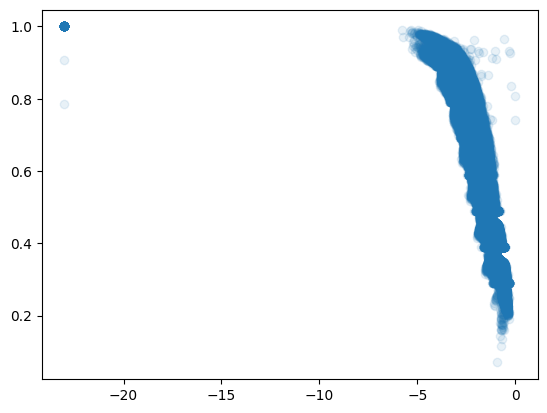

In [ ]:
plt.plot(df_no_background['log_FA'], df_no_background['ODI'], 'o', alpha=0.1)

In [ ]:

# For a true nonlinear fit with interaction, fit per (Tissue, Segment) group:
def exp_decay(fa, a, b, c):
    return a * np.exp(-b * fa) + c

fit_results = {}
for (tissue, segment), group in df.groupby(['Tissue', 'Segment']):
    try:
        popt, _ = curve_fit(exp_decay, group['FA'], group['ODI'], p0=(1, 1, 0), maxfev=10000)
        fit_results[(tissue, segment)] = popt
    except Exception as e:
        fit_results[(tissue, segment)] = None

print("Exponential decay fit parameters (a, b, c) for each tissue and segment:")
for key, params in fit_results.items():
    print(f"{key}: {params}")

## Calculate Slice Mean 

In [1]:
def slice_mean_sem(vol, mask, axis = (0, 1), sem = True): 
    """vol: (X,Y,Z) metric; mask: (X,Y,Z) bool"""
    # zero-out non-GM; mark them NaN for nan-reductions
    arr_masked = np.where(mask, vol, np.nan)
    mean_z = np.nanmean(arr_masked, axis=axis)

    n      = np.sum(np.isfinite(arr_masked), axis=axis)
    mean_z = np.nanmean(arr_masked,          axis=axis)
    var_z  = np.nanvar(arr_masked,           axis=axis, ddof=1)  # sample variance
    sem_z  = np.sqrt(var_z) / np.sqrt(n)
    sem_z  = np.where(n > 1, sem_z, np.nan)  # guard small n
    if sem == True:
        return mean_z, sem_z
    else:
        return mean_z, var_z

In [18]:
# Create boolean masks for each spinal region based on segment_z_index boundaries

# Cervical: C1 to C8
cervical_mask = np.zeros(mask.shape, dtype=bool)
cervical_start = 0
cervical_end = segment_z_index['C8']
cervical_mask[:, :, cervical_start:cervical_end+1] = True
cervical_gm = cervical_mask * mask_gm_OG
cervical_wm = cervical_mask * mask_wm_OG

# Thoracic: T1 to T12
thoracic_mask = np.zeros(mask.shape, dtype=bool)
thoracic_start = segment_z_index['C8']+1
thoracic_end = segment_z_index['T12']
thoracic_mask[:, :, thoracic_start:thoracic_end+1] = True
thoracic_gm = thoracic_mask * mask_gm_OG
thoracic_wm = thoracic_mask * mask_wm_OG

# Lumbar: L1 to L5
lumbar_mask = np.zeros(mask.shape, dtype=bool)
lumbar_start = segment_z_index['T12']+1
lumbar_end = segment_z_index['L5']
lumbar_mask[:, :, lumbar_start:lumbar_end+1] = True
lumbar_gm = lumbar_mask * mask_gm_OG
lumbar_wm = lumbar_mask * mask_wm_OG

# Sacral: S1 to S5
sacral_mask = np.zeros(mask.shape, dtype=bool)
sacral_start = segment_z_index['L5']+1
sacral_end = segment_z_index['S5']
sacral_mask[:, :, sacral_start:sacral_end] = True
sacral_gm = sacral_mask * mask_gm_OG
sacral_wm = sacral_mask * mask_wm_OG

In [38]:
ODI_mean_gm, ODI_SEM_gm = slice_mean_sem(ODI_NODDI,mask_gm_OG)
ODI_mean_wm, ODI_SEM_wm = slice_mean_sem(ODI_NODDI,mask_wm_OG)


ODI_mean_cervical_gm, ODI_SEM_cervical_gm = slice_mean_sem(ODI_NODDI, cervical_gm)
ODI_mean_cervical_wm, ODI_SEM_cervical_wm = slice_mean_sem(ODI_NODDI, cervical_wm)

ODI_mean_thoracic_gm, ODI_SEM_thoracic_gm = slice_mean_sem(ODI_NODDI, thoracic_gm)
ODI_mean_thoracic_wm, ODI_SEM_thoracic_wm = slice_mean_sem(ODI_NODDI, thoracic_wm)

ODI_mean_lumbar_gm, ODI_SEM_lumbar_gm = slice_mean_sem(ODI_NODDI, lumbar_gm)
ODI_mean_lumbar_wm, ODI_SEM_lumbar_wm = slice_mean_sem(ODI_NODDI, lumbar_wm)

ODI_mean_sacral_gm, ODI_SEM_sacral_gm = slice_mean_sem(ODI_NODDI, sacral_gm)
ODI_mean_sacral_wm, ODI_SEM_sacral_wm = slice_mean_sem(ODI_NODDI, sacral_wm)




fa = dti_fit.fa
ODI_mean_gm, ODI_SEM_gm = slice_mean_sem(fa,mask_gm_OG)
ODI_mean_wm, ODI_SEM_wm = slice_mean_sem(fa,mask_wm_OG)


FA_mean_cervical_gm, FA_SEM_cervical_gm = slice_mean_sem(fa, cervical_gm)
FA_mean_cervical_wm, FA_SEM_cervical_wm = slice_mean_sem(fa, cervical_wm)

FA_mean_thoracic_gm, FA_SEM_thoracic_gm = slice_mean_sem(fa, thoracic_gm)
FA_mean_thoracic_wm, FA_SEM_thoracic_wm = slice_mean_sem(fa, thoracic_wm)

FA_mean_lumbar_gm, FA_SEM_lumbar_gm = slice_mean_sem(fa, lumbar_gm)
FA_mean_lumbar_wm, FA_SEM_lumbar_wm = slice_mean_sem(fa, lumbar_wm)

FA_mean_sacral_gm, FA_SEM_sacral_gm = slice_mean_sem(fa, sacral_gm)
FA_mean_sacral_wm, FA_SEM_sacral_wm = slice_mean_sem(fa, sacral_wm)



C:\Users\sigur\AppData\Local\Temp\ipykernel_27112\2767487483.py:5: RuntimeWarning: Mean of empty slice
  mean_z = np.nanmean(arr_masked, axis=axis)
C:\Users\sigur\AppData\Local\Temp\ipykernel_27112\2767487483.py:8: RuntimeWarning: Mean of empty slice
  mean_z = np.nanmean(arr_masked,          axis=axis)
C:\Users\sigur\AppData\Local\Temp\ipykernel_27112\2767487483.py:9: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_z  = np.nanvar(arr_masked,           axis=axis, ddof=1)  # sample variance


In [39]:
print(np.nanmean(FA_mean_thoracic_wm))
np.nanmean(FA_mean_thoracic_gm)

0.46759367404547714


np.float64(0.3684101665079054)

In [31]:
np.nanmean(ODI_mean_lumbar_gm)

np.float32(0.62350166)

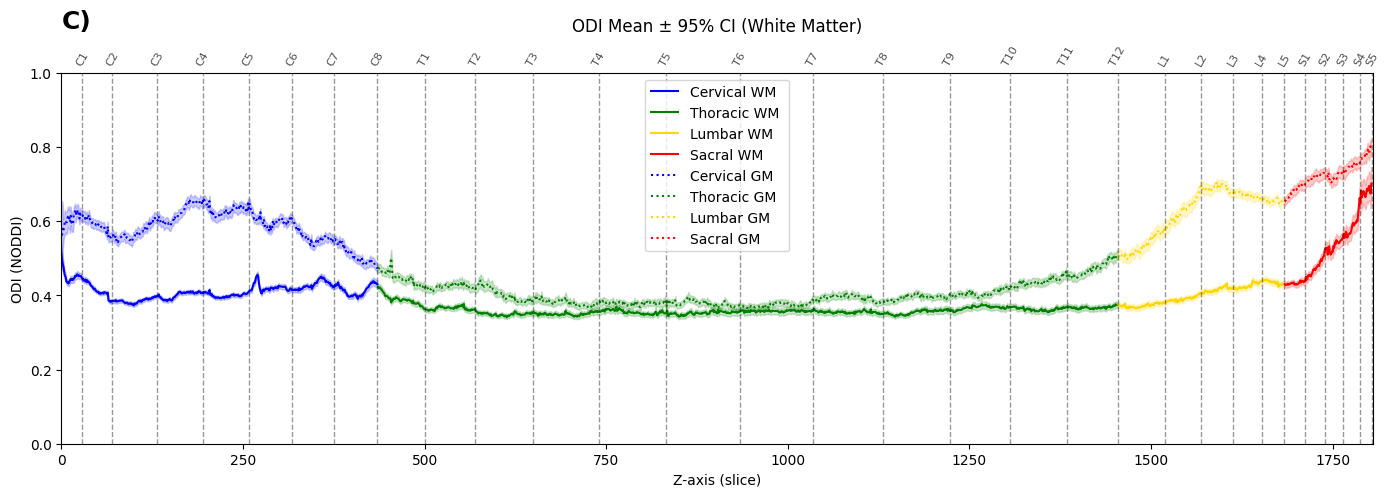

In [ ]:
regions = [
    ("Cervical WM", ODI_mean_cervical_wm, ODI_SEM_cervical_wm, 'blue'),
    ("Thoracic WM ", ODI_mean_thoracic_wm, ODI_SEM_thoracic_wm, 'green'),
    ("Lumbar WM" , ODI_mean_lumbar_wm, ODI_SEM_lumbar_wm, 'gold'),
    ("Sacral WM", ODI_mean_sacral_wm, ODI_SEM_sacral_wm, 'red')
]

regions_gm = [
    ("Cervical GM", ODI_mean_cervical_gm, ODI_SEM_cervical_gm, 'blue'),
    ("Thoracic GM", ODI_mean_thoracic_gm, ODI_SEM_thoracic_gm, 'green'),
    ("Lumbar GM", ODI_mean_lumbar_gm, ODI_SEM_lumbar_gm, 'gold'),
    ("Sacral GM", ODI_mean_sacral_gm, ODI_SEM_sacral_gm, 'red')
]

plt.figure(figsize=(12, 5))

for name, mean, sem, color in regions:
    plt.plot(mean, label=f"{name}", color=color, linestyle = "-")
    plt.fill_between(np.arange(len(mean)), mean-1.96*sem, mean+1.96*sem, color=color, alpha=0.2)

for name, mean, sem, color in regions_gm:
    plt.plot(mean, label=f"{name}", color=color, linestyle = ":")
    plt.fill_between(np.arange(len(mean)), mean-1.96*sem, mean+1.96*sem, color=color, alpha=0.2)

# Add vertical lines for segment boundaries
for seg, z_idx in segment_z_index.items():
    plt.axvline(z_idx, color='k', linestyle='--', alpha=0.4, linewidth=1)
    plt.text(z_idx, plt.ylim()[1] + 0.17, seg, rotation=60, va='bottom', ha='center', fontsize=8, alpha=0.7)

plt.xlabel('Z-axis (slice)')
plt.ylim(0, 1)
plt.xlim(0,1805)
plt.ylabel('ODI (NODDI)')
plt.title('ODI Mean ± 95% CI (White Matter)', pad = 30)
plt.legend()
plt.tight_layout()
plt.text(0, 1.12, "C)", fontsize=18, fontweight = "bold")
plt.savefig('figures/NODDI/ODI_NODDI_Mean_95CI_WM_GM_all_spinal_segments_with_boundaries.svg', dpi=2000, bbox_inches='tight')
plt.show()

In [ ]:
arr_masked = np.where(mask_gm, ODI_NODDI, np.nan)
mean_gm = np.nanmean(arr_masked, axis=(0,1,2))


n      = np.sum(np.isfinite(arr_masked), axis=(0,1,2))
mean_z = np.nanmean(arr_masked,          axis=(0,1,2))
var_gm  = np.nanvar(arr_masked,           axis=(0,1,2), ddof=1)  # sample variance
sem_z  = np.sqrt(var_gm) / np.sqrt(n)
sem_gm  = np.where(n > 1, sem_z, np.nan)  # guard small n


arr_masked = np.where(mask_wm, ODI_NODDI, np.nan)
mean_wm= np.nanmean(arr_masked, axis=(0,1,2))

n      = np.sum(np.isfinite(arr_masked), axis=(0,1,2))
mean_z = np.nanmean(arr_masked,          axis=(0,1,2))
var_wm  = np.nanvar(arr_masked,           axis=(0,1,2), ddof=1)  # sample variance
sem_z  = np.sqrt(var_wm) / np.sqrt(n)
sem_wm  = np.where(n > 1, sem_z, np.nan)  # guard small n

In [135]:
sacral_wm_mean, sacral_wm_SEM =  slice_mean_sem(ODI_NODDI, sacral_wm, axis = (0,1,2), sem = False)
lumbar_wm_mean, lumbar_wm_SEM =  slice_mean_sem(ODI_NODDI, lumbar_wm, axis = (0,1,2), sem = False)
thoracic_wm_mean, thoracic_wm_SEM =  slice_mean_sem(ODI_NODDI, thoracic_wm, axis = (0,1,2), sem = False)
cervical_wm_mean, cervical_wm_SEM =  slice_mean_sem(ODI_NODDI, cervical_wm, axis = (0,1,2), sem = False)

import pandas as pd

# Create a matrix of means and SEMs for each region
data = {
    "Region": ["Cervical WM", "Thoracic WM", "Lumbar WM", "Sacral WM"],
    "Mean": [
        float(cervical_wm_mean),
        float(thoracic_wm_mean),
        float(lumbar_wm_mean),
        float(sacral_wm_mean)
    ],
    "SD": [
        float(cervical_wm_SEM),
        float(thoracic_wm_SEM),
        float(lumbar_wm_SEM),
        float(sacral_wm_SEM)
    ]
}

df = pd.DataFrame(data)
print(df)

        Region      Mean        SD
0  Cervical WM  0.407753  0.011944
1  Thoracic WM  0.359361  0.012006
2    Lumbar WM  0.403520  0.012455
3    Sacral WM  0.485838  0.021863


In [134]:
sacral_gm_mean, sacral_gm_SEM =  slice_mean_sem(ODI_NODDI, sacral_gm, axis = (0,1,2), sem = False)
lumbar_gm_mean, lumbar_gm_SEM =  slice_mean_sem(ODI_NODDI, lumbar_gm, axis = (0,1,2), sem = False)
thoracic_gm_mean, thoracic_gm_SEM =  slice_mean_sem(ODI_NODDI, thoracic_gm, axis = (0,1,2), sem = False)
cervical_gm_mean, cervical_gm_SEM =  slice_mean_sem(ODI_NODDI, cervical_gm, axis = (0,1,2), sem = False)

import pandas as pd

# Create a matrix of means and SEMs for each region
data_gm = {
    "Region": ["Cervical GM", "Thoracic GM", "Lumbar GM", "Sacral GM"],
    "Mean": [
        float(cervical_gm_mean),
        float(thoracic_gm_mean),
        float(lumbar_gm_mean),
        float(sacral_gm_mean)
    ],
    "SD": [
        float(cervical_gm_SEM),
        float(thoracic_gm_SEM),
        float(lumbar_gm_SEM),
        float(sacral_gm_SEM)
    ]
}

df_gm = pd.DataFrame(data_gm)
print(df_gm)

        Region      Mean        SD
0  Cervical GM  0.591681  0.013768
1  Thoracic GM  0.409224  0.003993
2    Lumbar GM  0.642513  0.017827
3    Sacral GM  0.714888  0.020791


In [136]:
segment_masks_gm = {}
segment_masks_wm = {}

segments = list(segment_z_index.keys())
for i, seg in enumerate(segments):
    z_start = 0 if i == 0 else segment_z_index[segments[i-1]] + 1
    z_end = segment_z_index[seg]
    mask_seg = np.zeros(mask.shape, dtype=bool)
    mask_seg[:, :, z_start:z_end+1] = True
    segment_masks_gm[seg] = mask_seg & mask_gm
    segment_masks_wm[seg] = mask_seg & mask_wm


In [144]:
# Calculate mean and SEM for each segment in GM and WM using slice_mean_sem
segment_stats_gm = {}
segment_stats_wm = {}

for seg in segments:
    mask_gm_seg = segment_masks_gm[seg]
    mask_wm_seg = segment_masks_wm[seg]
    # Use ODI_NODDI and mask_gm/mask_wm for each segment
    mean_gm, sem_gm = slice_mean_sem(ODI_NODDI, mask_gm_seg, axis=(0,1,2), sem=False)
    mean_wm, sem_wm = slice_mean_sem(ODI_NODDI, mask_wm_seg, axis=(0,1,2), sem=False)
    segment_stats_gm[seg] = {'mean': float(mean_gm), 'sem': float(sem_gm)}
    segment_stats_wm[seg] = {'mean': float(mean_wm), 'sem': float(sem_wm)}

print("GM segment stats:", segment_stats_gm)
print("WM segment stats:", segment_stats_wm)

GM segment stats: {'C1': {'mean': 0.614587664604187, 'sem': 0.00995983649045229}, 'C2': {'mean': 0.5868395566940308, 'sem': 0.009472223930060863}, 'C3': {'mean': 0.5708053708076477, 'sem': 0.01131587103009224}, 'C4': {'mean': 0.6261305212974548, 'sem': 0.01679253950715065}, 'C5': {'mean': 0.6292667388916016, 'sem': 0.01705448143184185}, 'C6': {'mean': 0.601309061050415, 'sem': 0.011238288134336472}, 'C7': {'mean': 0.5584262609481812, 'sem': 0.008244110271334648}, 'C8': {'mean': 0.5106954574584961, 'sem': 0.007147870026528835}, 'T1': {'mean': 0.44848325848579407, 'sem': 0.005359731148928404}, 'T2': {'mean': 0.42372927069664, 'sem': 0.0031677575316280127}, 'T3': {'mean': 0.40503066778182983, 'sem': 0.004489935003221035}, 'T4': {'mean': 0.3807504177093506, 'sem': 0.0023797298781573772}, 'T5': {'mean': 0.378378689289093, 'sem': 0.0018344366690143943}, 'T6': {'mean': 0.3777690827846527, 'sem': 0.001753200893290341}, 'T7': {'mean': 0.37383148074150085, 'sem': 0.0015674915630370378}, 'T8': {'

In [ ]:
plt.figure(figsize=(15, 6))
offset = 0.3  # increase ½separation
parts1 = plt.violinplot(odi_per_segment_gm, positions=positions - offset, showmeans=True, widths=0.5, showextrema=False)
parts2 = plt.violinplot(odi_per_segment_wm, positions=positions + offset, showmeans=True, widths=0.5, showextrema=False)

plt.errorbar(positions - offset, gm_means, yerr=np.array(gm_sems) * 1.96, fmt='o', color='black', label='GM 95% CI', capsize=4)
plt.errorbar(positions + offset, wm_means, yerr=np.array(wm_sems) * 1.96, fmt='o', color='gray', label='WM 95% CI', capsize=4)

plt.xticks(positions, segments, rotation=90)
plt.ylabel('ODI (NODDI)')
plt.title('ODI Distribution per Spinal Segment (GM vs WM)')
plt.legend([parts1["bodies"][0], parts2["bodies"][0], 
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', label='GM 95% CI'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', label='WM 95% CI')],
           ['Gray Matter', 'White Matter', 'GM 95% CI', 'WM 95% CI'])
plt.tight_layout()
plt.show()


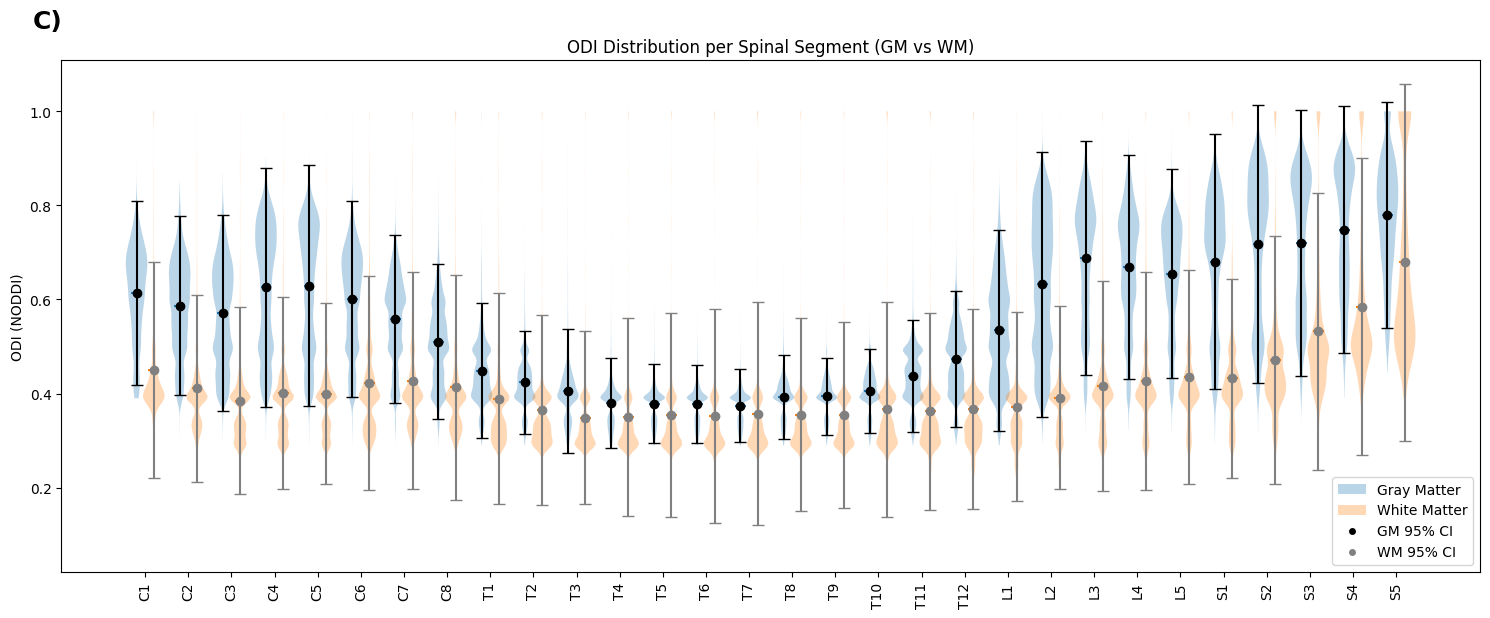

In [182]:
# Collect ODI values per segment for GM and WM
odi_per_segment_gm = []
odi_per_segment_wm = []
gm_means = []
gm_sems = []
wm_means = []
wm_sems = []

for seg in segments:
    mask_gm_seg = segment_masks_gm[seg]
    mask_wm_seg = segment_masks_wm[seg]
    # Flatten and remove NaNs for each segment
    odi_gm_vals = ODI_NODDI[mask_gm_seg].flatten()
    odi_gm_vals = odi_gm_vals[~np.isnan(odi_gm_vals)]
    odi_per_segment_gm.append(odi_gm_vals)
    gm_means.append(np.mean(odi_gm_vals))
    gm_sems.append(np.std(odi_gm_vals, ddof=1))

    odi_wm_vals = ODI_NODDI[mask_wm_seg].flatten()
    odi_wm_vals = odi_wm_vals[~np.isnan(odi_wm_vals)]
    odi_per_segment_wm.append(odi_wm_vals)
    wm_means.append(np.mean(odi_wm_vals))
    wm_sems.append(np.std(odi_wm_vals, ddof=1))

positions = np.arange(len(segments))

plt.figure(figsize=(15, 6))
offset = .2
parts1 = plt.violinplot(odi_per_segment_gm, positions=positions-offset, showmeans=True, widths=0.5, showextrema=False)
parts2 = plt.violinplot(odi_per_segment_wm, positions=positions+offset, showmeans=True, widths=0.5, showextrema=False)

# Add 95% CI error bars for means
plt.errorbar(positions-offset, gm_means, yerr=np.array(gm_sems)*1.96, fmt='o', color='black', label='GM 95% CI', capsize=4)
plt.errorbar(positions+offset, wm_means, yerr=np.array(wm_sems)*1.96, fmt='o', color='gray', label='WM 95% CI', capsize=4)


plt.xticks(positions, segments, rotation=90)


plt.ylabel('ODI (NODDI)')
plt.title('ODI Distribution per Spinal Segment (GM vs WM)')
plt.legend([parts1["bodies"][0], parts2["bodies"][0], 
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', label='GM 95% CI'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', label='WM 95% CI')],
           ['Gray Matter', 'White Matter', 'GM 95% CI', 'WM 95% CI'])
plt.tight_layout()
plt.text(-0.02,1.1, "C)", transform=plt.gca().transAxes, fontsize=18, fontweight='bold', va = "top", ha = "left")

plt.savefig('figures/NODDI/ODI_NODDI_Violin_Plots_GM_vs_WM_all_spinal_segments_with_95CI.svg', dpi=2000, bbox_inches='tight')
plt.show()

## RGB Colored Plots

In [98]:
from scipy.ndimage import rotate

fig, axes = plt.subplots(2, 2, figsize=(12, 12), dpi = 1000)

for ax_idx, (seg, idx) in enumerate(plot_idx_dict.items()):
    d = dir_NODDI[:, :, idx, :]    # (X, Y, 3)
    t2_slice = t2_trans_in_b0_space[:, :, idx]

    # Rotate d and image by -rotated_angles[idx] around the z-axis (axis=(0,1)), reshape=False to keep size
    d_rot = rotate(d, angle=-rotated_angles[idx], axes=(0, 1), reshape=False, order=1, mode='nearest')
    t2_rot = rotate(t2_slice, angle=-rotated_angles[idx], axes=(0, 1), reshape=False, order=1, mode='nearest')

    # Normalize per voxel; use abs to remove sign ambiguity
    norm = np.linalg.norm(d_rot, axis=-1, keepdims=True)
    unit = np.divide(d_rot, norm, out=np.zeros_like(d_rot), where=norm > 0)
    rgb = np.abs(unit)  # map: x->R, y->G, z->B

    rgb = rgb[5:-25, 6:-8, :]
    t2_rot = t2_rot[5:-25, 6:-8]
    ax = axes[ax_idx // 2, ax_idx % 2]
    ax.imshow(rgb, alpha=1)
    ax.imshow(t2_rot, cmap='gray', alpha=0.6)
    ax.set_title(f"{seg}", fontsize=18, fontweight='bold')
    ax.axis('off')

fig.suptitle('Principal Neurite Directions', fontsize=22, fontweight='bold')
fig.text(0, 0, 'Green = Lateral, Red = Vental-Dorsal & Blue = Rostral-Caudal ', transform=axes[0, 0].transAxes,
            fontsize=12, fontweight='bold', va='center', ha='right', rotation=90)
plt.tight_layout()

plt.savefig('figures/NODDI/Principal_Neural_Directions_per_segment_overlay_4_images.svg', dpi=5000, bbox_inches='tight')
plt.show()


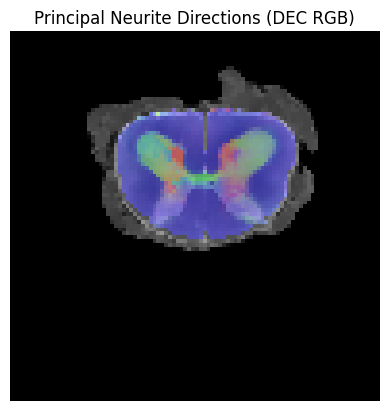

In [ ]:
import matplotlib.pyplot as plt



slice_k =  1613  # pick a slice
d = dir_NODDI[:, :, slice_k, :]    # (X, Y, 3)

# Normalize per voxel; use abs to remove sign ambiguity
norm = np.linalg.norm(d, axis=-1, keepdims=True)
unit = np.divide(d, norm, out=np.zeros_like(d), where=norm>0)
rgb  = np.abs(unit)               # map: x->R, y->G, z->B

# Optional: modulate by anisotropy proxy (e.g., NDI*(1-FWF)) to fade low-confidence voxels
# w = ndi_slice * (1 - fwf_slice); rgb *= w[..., None] / (w.max() + 1e-8)

plt.imshow(rgb, alpha = 1)
plt.imshow(t2_trans_in_b0_space[:, :, slice_k], cmap='gray', alpha=0.6)  # optional T2 overlay
plt.title('Principal Neurite Directions (DEC RGB)')
plt.axis('off')
plt.show()


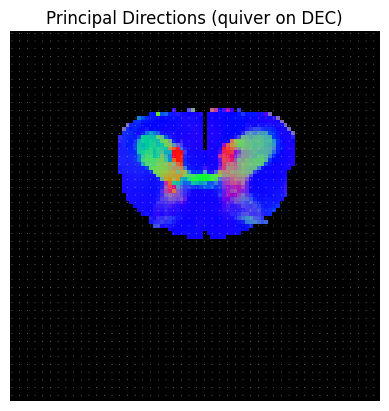

In [41]:
step = 2  # stride for arrows
yy, xx = np.mgrid[0:rgb.shape[0]:step, 0:rgb.shape[1]:step]
vec = unit[::step, ::step, :]  # (X/step, Y/step, 3)
u, v = vec[..., 0], vec[..., 1]  # X and Y components in slice plane

plt.imshow(rgb)
plt.quiver(xx, yy, u, v, color='white', angles='xy', scale_units='xy', scale=20, width=0.002)
plt.title('Principal Directions (quiver on DEC)')
plt.axis('off')
plt.show()


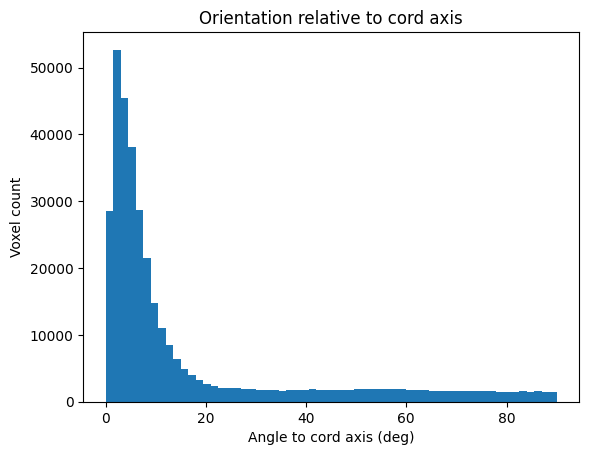

In [45]:
axis = np.array([0, 0, 1.0])   # change if your axis differs
v = dir_NODDI[mask == True]             # (N,3)
v = v / (np.linalg.norm(v, axis=-1, keepdims=True) + 1e-8)
cosang = np.abs((v @ axis))    # abs removes sign ambiguity
angle_deg = np.degrees(np.arccos(np.clip(cosang, 0, 1)))

# Example: histogram
import matplotlib.pyplot as plt
plt.hist(angle_deg, bins=60, range=(0,90))
plt.xlabel('Angle to cord axis (deg)')
plt.ylabel('Voxel count')
plt.title('Orientation relative to cord axis')
plt.show()


C:\Users\sigur\AppData\Local\Temp\ipykernel_19472\1429717130.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


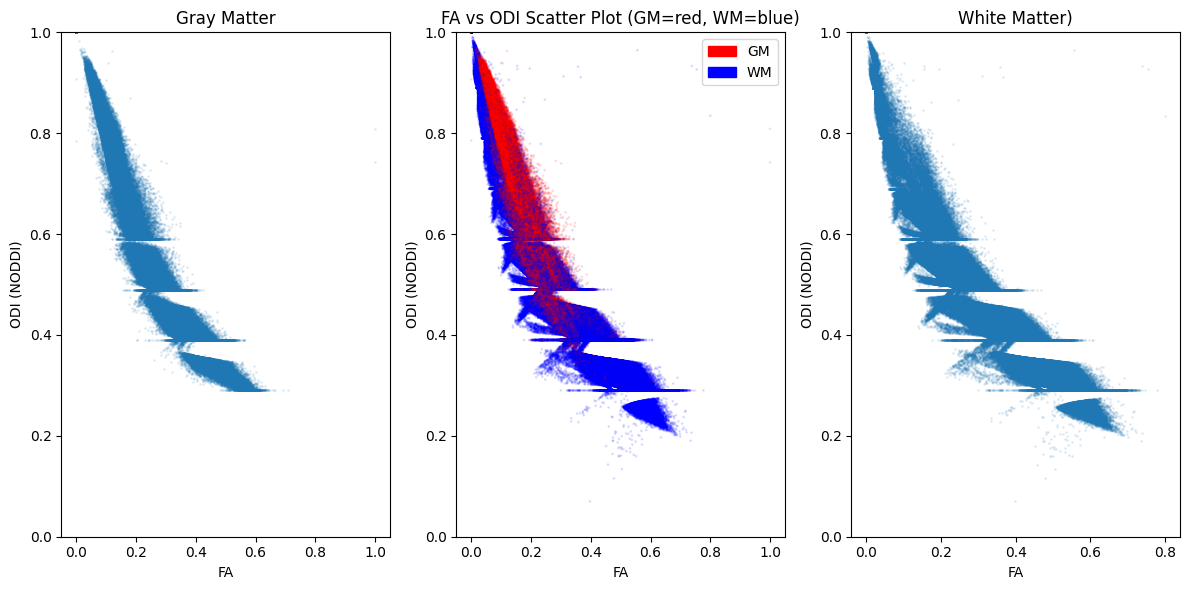

In [91]:
plt.figure(figsize=(12, 6))

plt.subplot(1,3,1)
scatter = plt.scatter(fa_gm,odi_gm, alpha=0.1, s=1)
plt.xlabel('FA')
plt.ylabel('ODI (NODDI)')
plt.title('Gray Matter')
plt.ylim(0,1)

plt.subplot(1,3,2)
scatter = plt.scatter(fa_valid,odi_valid, c=colors, alpha=0.1, s=1)
plt.xlabel('FA')
plt.ylabel('ODI (NODDI)')
plt.title('FA vs ODI Scatter Plot (GM=red, WM=blue)')
plt.ylim(0,1)

# Add legend for colors
red_patch = mpatches.Patch(color='red', label='GM')
blue_patch = mpatches.Patch(color='blue', label='WM')
plt.legend(handles=[red_patch, blue_patch])


plt.subplot(1,3,3)
scatter = plt.scatter(fa_wm,odi_wm, alpha=0.1, s=1)
plt.xlabel('FA')
plt.ylabel('ODI (NODDI)')
plt.title('White Matter)')
plt.ylim(0,1)

plt.tight_layout()
plt.show()

## **GRAY MATTER**

In [184]:
# First, create a reverse mapping from z-index to segment label
z_to_segment = np.empty(ODI_NODDI.shape[2], dtype=object)
sorted_segments = sorted(segment_z_index.items(), key=lambda x: x[1])
for i, (seg, z_idx) in enumerate(sorted_segments):
    start = sorted_segments[i-1][1]+1 if i > 0 else 0
    end = z_idx
    z_to_segment[start:end+1] = seg

# Get the z indices for each GM voxel
gm_indices = np.where(mask == 1)
z_indices_gm = gm_indices[2]

# Map each GM voxel to its segment
gm_segments = z_to_segment[z_indices_gm]

# Assign a color to each segment
import matplotlib.cm as cm
import matplotlib.colors as mcolors

unique_segments = list(segment_z_index.keys())
cmap = cm.get_cmap('tab20', len(unique_segments))
segment_to_color = {seg: mcolors.rgb2hex(cmap(i)) for i, seg in enumerate(unique_segments)}
colors_gm = [segment_to_color[seg] for seg in gm_segments]


C:\Users\sigur\AppData\Local\Temp\ipykernel_49288\3329446076.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_segments))


In [ ]:
from scipy.optimize import curve_fit
import numpy as np

import matplotlib.pyplot as plt

# Define exponential decay function: ODI = a * exp(-b * FA) + c
def exp_decay(fa, a, b, c):
    return a * np.exp(-b * fa) + c

fit_params = {}
fit_curves = {}

for i, seg in enumerate(segments):
    odi_vals = odi_per_segment_wm[i]
    # You need the corresponding FA values for each segment
    # Assuming you have a list: fa_per_segment_wm (same structure as odi_per_segment_wm)
    fa_vals = fa_per_segment_wm[i]  # Make sure this exists and matches ODI

    # Remove NaNs if any
    mask = ~np.isnan(fa_vals) & ~np.isnan(odi_vals)
    fa_vals = fa_vals[mask]
    odi_vals = odi_vals[mask]

    # Fit the exponential decay
    try:
        popt, pcov = curve_fit(exp_decay, fa_vals, odi_vals, p0=(1, 1, 0))
        fit_params[seg] = popt
        # Store fitted curve for plotting
        fa_fit = np.linspace(fa_vals.min(), fa_vals.max(), 100)
        odi_fit = exp_decay(fa_fit, *popt)
        fit_curves[seg] = (fa_fit, odi_fit)
    except Exception as e:
        print(f"Fit failed for segment {seg}: {e}")
        fit_params[seg] = None
        fit_curves[seg] = None

# Example: plot for one segment
seg = segments[0]
fa_vals = fa_per_segment_wm[0]
odi_vals = odi_per_segment_wm[0]
fa_fit, odi_fit = fit_curves[seg]

plt.scatter(fa_vals, odi_vals, alpha=0.1, s=1, label='Data')
plt.plot(fa_fit, odi_fit, color='red', label='Exp. Decay Fit')
plt.xlabel('FA')
plt.ylabel('ODI')
plt.title(f'Exponential Decay Fit: {seg}')
plt.legend()
plt.show()

In [183]:
fa_gm

NameError: name 'fa_gm' is not defined

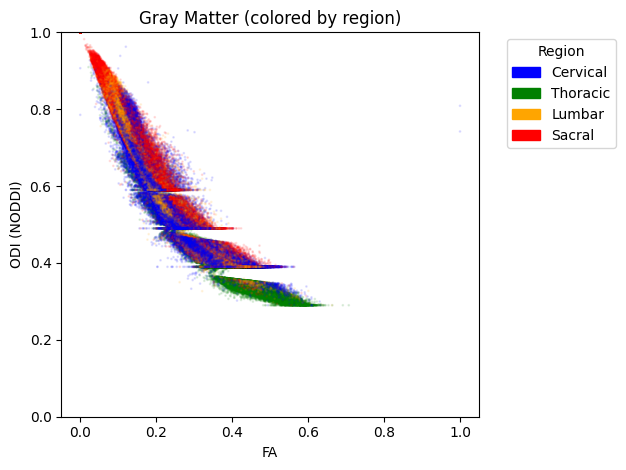

In [ ]:
# Assign region color for each GM voxel based on its segment
region_color_map = {'C': 'blue', 'T': 'green', 'L': 'orange', 'S': 'red'}
region_title_map = {'C': 'Cervical', 'T': 'Thoracic', 'L': 'Lumbar', 'S': 'Sacral'}
gm_region = [seg[0] for seg in gm_segments]  # First letter: C, T, L, S
region_colors_gm = [region_color_map[r] for r in gm_region]

plt.scatter(fa_gm, odi_gm, c=region_colors_gm, alpha=0.1, s=1)
plt.xlabel('FA')
plt.ylabel('ODI (NODDI)')
plt.title('Gray Matter (colored by region)')
plt.ylim(0, 1)

# Add legend with full region names
import matplotlib.patches as mpatches
handles = [
    mpatches.Patch(color=region_color_map[r], label=region_title_map[r])
    for r in region_color_map
]
plt.legend(handles=handles, title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\sigur\AppData\Local\Temp\ipykernel_19472\4015612195.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn_r')  # green -> red


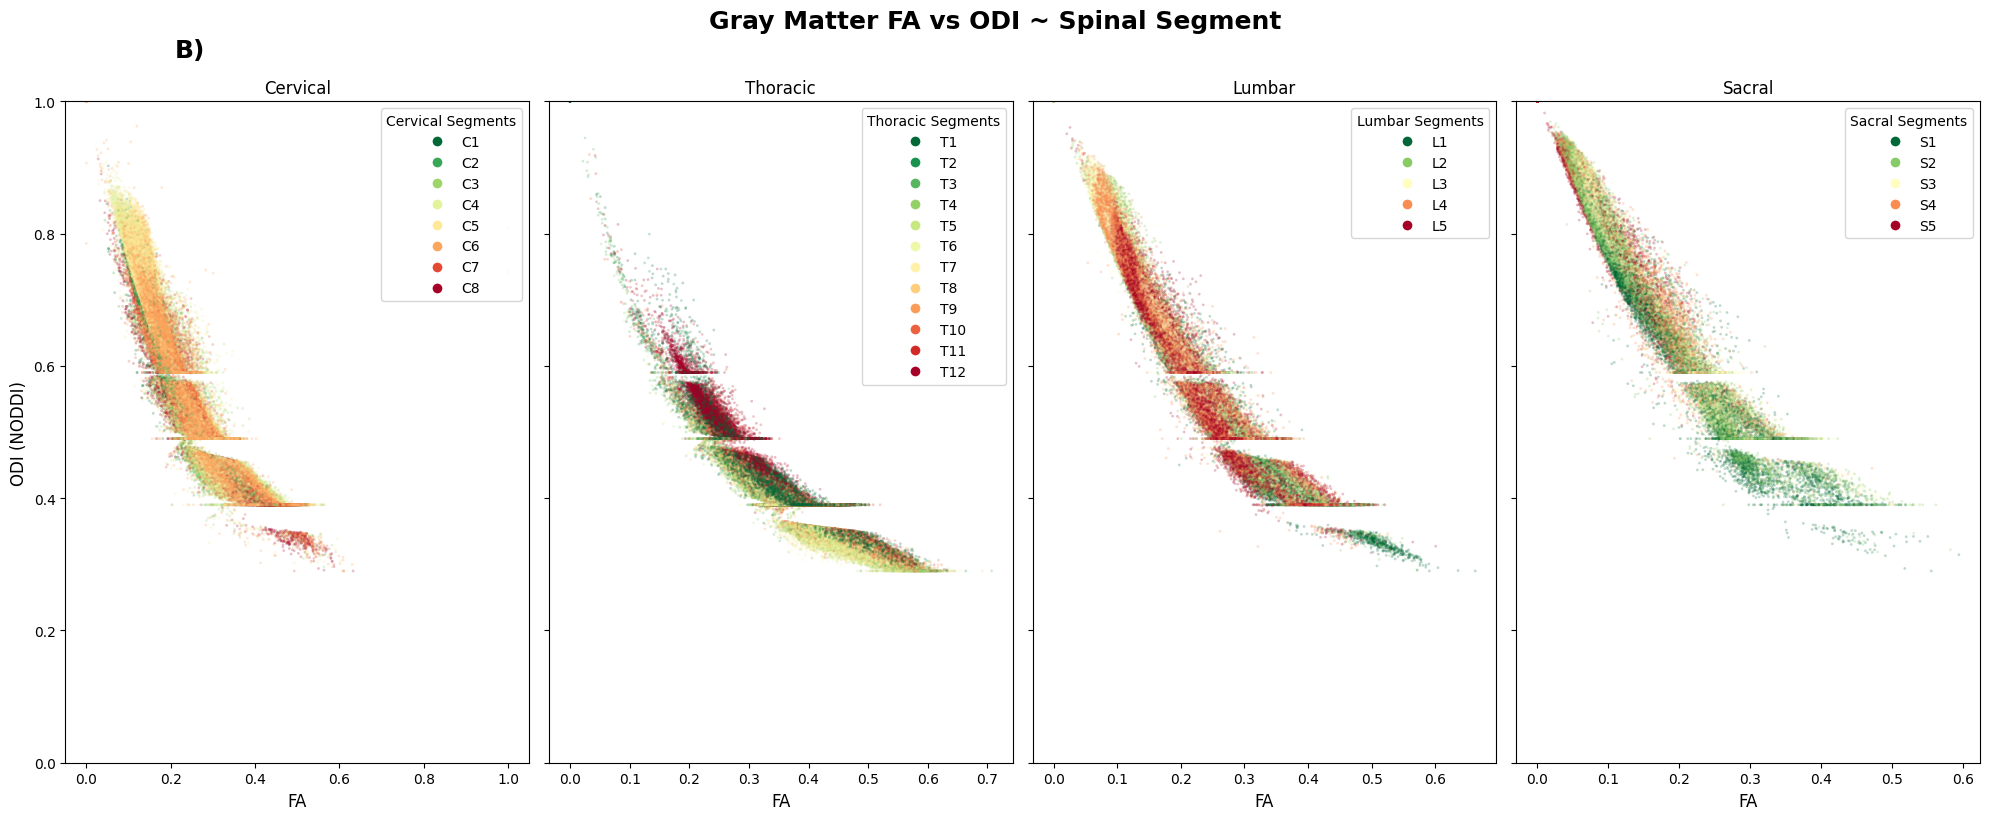

In [155]:
import re
from matplotlib import cm


# Group segments by region
region_map = {'C': [], 'T': [], 'L': [], 'S': []}
for seg in unique_segments:
    region_map[seg[0]].append(seg)

region_labels = ['C', 'T', 'L', 'S']
region_titles = {'C': 'Cervical', 'T': 'Thoracic', 'L': 'Lumbar', 'S': 'Sacral'}

# Natural sort key for segments like 'C1','C10','T2', etc.
def seg_num(seg):
    m = re.search(r'(\d+)', seg)
    return int(m.group(1)) if m else 0

cmap = cm.get_cmap('RdYlGn_r')  # green -> red

fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharey=True)

for i, region in enumerate(region_labels):
    # Segments in this region, sorted rostral->caudal
    segs_in_region = sorted(region_map[region], key=seg_num)
    nseg = len(segs_in_region)

    # Assign each segment a color along the green->red gradient
    # (evenly spaced across the colormap)
    if nseg > 1:
        colors_for_segs = {seg: cmap(j/(nseg-1)) for j, seg in enumerate(segs_in_region)}
    else:
        colors_for_segs = {segs_in_region[0]: cmap(0.5)}

    # Mask voxels belonging to this region and color by their segment
    region_mask = np.isin(gm_segments, segs_in_region)
    seg_labels_region = np.array(gm_segments)[region_mask]
    point_colors = [colors_for_segs[seg] for seg in seg_labels_region]

    axes[i].scatter(
        fa_gm[region_mask],
        odi_gm[region_mask],
        c=point_colors,
        alpha=0.25,
        s=4,
        linewidths=0
    )

    axes[i].set_title(region_titles[region])
    axes[i].set_xlabel('FA', fontsize = 12)
    if i == 0:
        axes[i].set_ylabel('ODI (NODDI)', fontsize = 12)
    axes[i].set_ylim(0, 1)

    # Legend: one handle per segment with its gradient color
    handles = [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=colors_for_segs[seg], markersize=8, label=seg)
        for seg in segs_in_region
    ]
    axes[i].legend(handles=handles, title=f"{region_titles[region]} Segments",
                   loc='upper right', fontsize='medium', title_fontsize='medium')

fig.suptitle('Gray Matter FA vs ODI ~ Spinal Segment',fontweight = "bold", fontsize=18, y=1.02)
fig.text(0.09,0.96,"B)", fontsize=18, fontweight='bold' )

plt.savefig('figures/NODDI/GM_FA_vs_ODI_by_Spinal_Segment_Colored_by_Segment.png', dpi=2000, bbox_inches='tight')
plt.tight_layout()
plt.show()


C:\Users\sigur\AppData\Local\Temp\ipykernel_19472\318689090.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('RdYlGn_r')


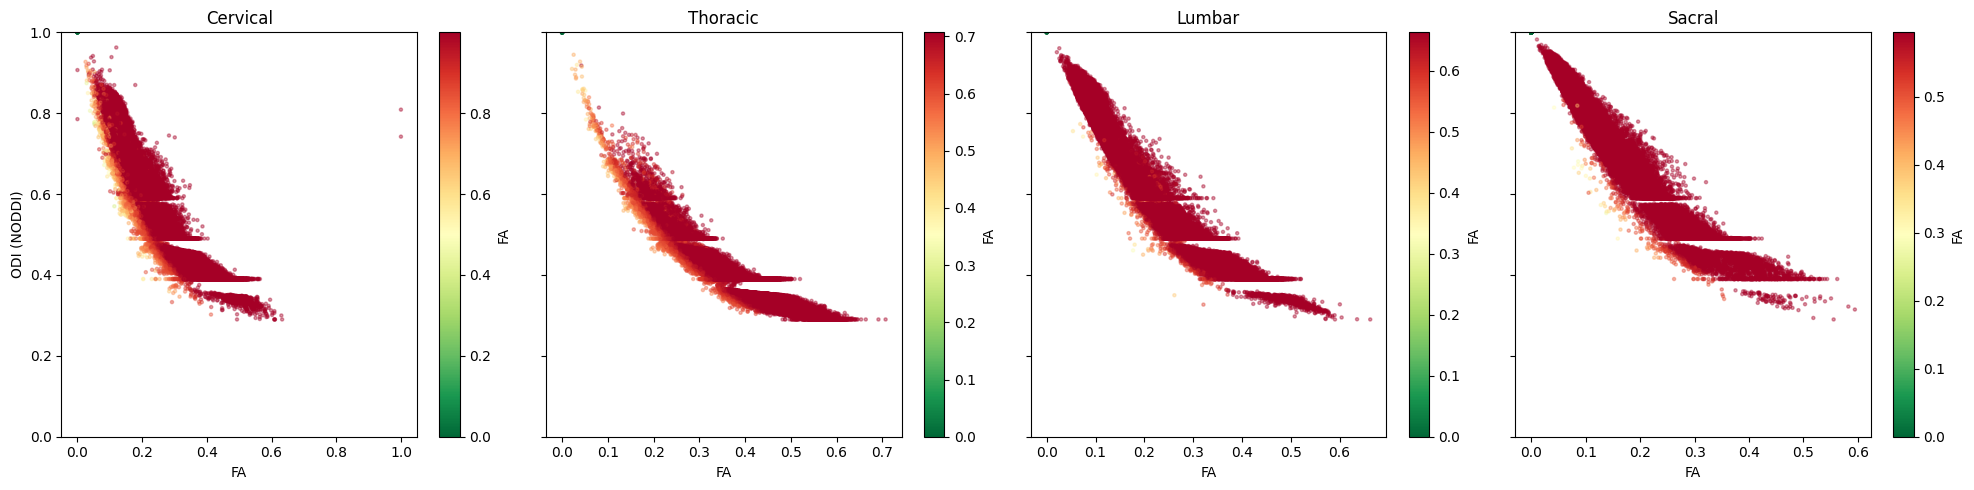

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Colormap (green to red)
cmap = get_cmap('RdYlGn_r')  

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for i, region in enumerate(region_labels):
    region_mask = np.isin(gm_segments, region_map[region])

    # Normalize FA for coloring in this region
    fa_region = ndi_gm[region_mask]
    norm = (fa_region - fa_region.min()) / (fa_region.max() - fa_region.min())
    colors_region = cmap(norm)

    fa_region = fa_gm[region_mask]

    axes[i].scatter(
        fa_region, odi_gm[region_mask],
        c=colors_region, alpha=0.4, s=5
    )

    axes[i].set_title(region_titles[region])
    axes[i].set_xlabel('FA')
    if i == 0:
        axes[i].set_ylabel('ODI (NODDI)')
    axes[i].set_ylim(0, 1)

    # Add colorbar for each subplot
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=fa_region.min(), vmax=fa_region.max()))
    sm.set_array([])
    fig.colorbar(sm, ax=axes[i], label='FA')

plt.tight_layout()
plt.show()


## **White Matter**

In [50]:
# First, create a reverse mapping from z-index to segment label
z_to_segment = np.empty(ODI_NODDI.shape[2], dtype=object)
sorted_segments = sorted(segment_z_index.items(), key=lambda x: x[1])
for i, (seg, z_idx) in enumerate(sorted_segments):
    start = sorted_segments[i-1][1]+1 if i > 0 else 0
    end = z_idx
    z_to_segment[start:end+1] = seg

# Get the z indices for each WM voxel
wm_indices = np.where(mask == 2)
z_indices_wm = wm_indices[2]

# Map each WM voxel to its segment
wm_segments = z_to_segment[z_indices_wm]

# Assign a color to each segment
import matplotlib.cm as cm
import matplotlib.colors as mcolors

unique_segments = list(segment_z_index.keys())
cmap = cm.get_cmap('tab20', len(unique_segments))
segment_to_color = {seg: mcolors.rgb2hex(cmap(i)) for i, seg in enumerate(unique_segments)}

colors_wm = [segment_to_color[seg] for seg in wm_segments]

C:\Users\sigur\AppData\Local\Temp\ipykernel_30600\1530675025.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_segments))


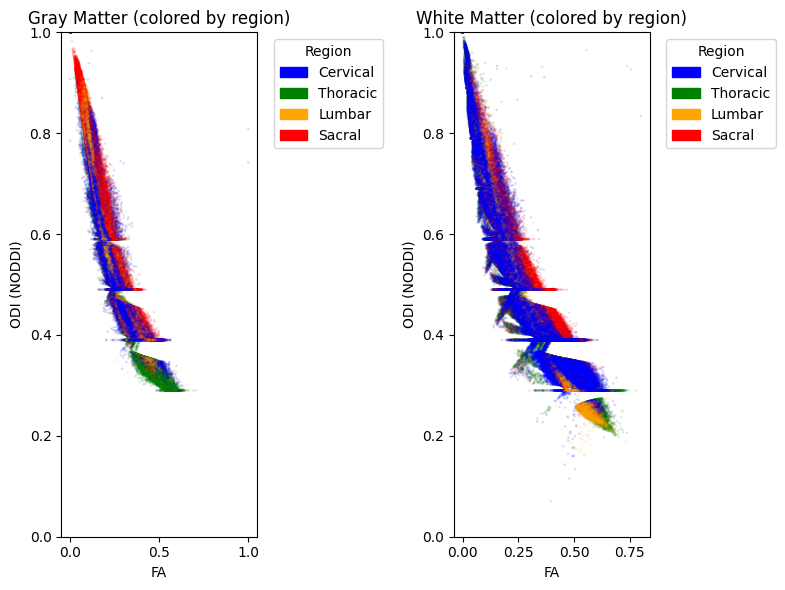

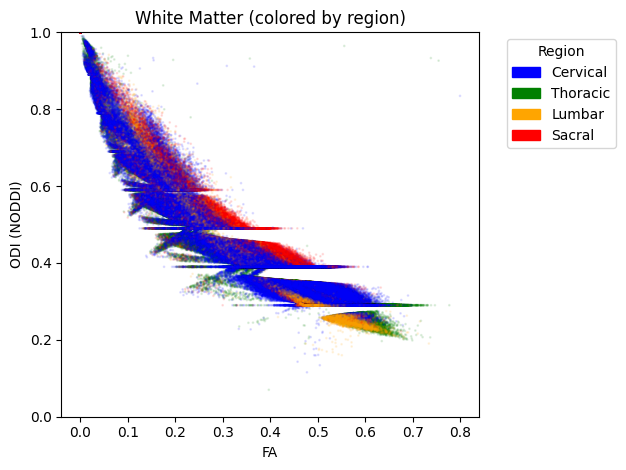

In [51]:
# Assign region color for each GM voxel based on its segment
region_color_map = {'C': 'blue', 'T': 'green', 'L': 'orange', 'S': 'red'}
region_title_map = {'C': 'Cervical', 'T': 'Thoracic', 'L': 'Lumbar', 'S': 'Sacral'}
wm_region = [seg[0] for seg in wm_segments]  # First letter: C, T, L, S
region_colors_wm = [region_color_map[r] for r in wm_region]

plt.scatter(fa_wm, odi_wm, c=region_colors_wm, alpha=0.1, s=1)
plt.xlabel('FA')
plt.ylabel('ODI (NODDI)')
plt.title('White Matter (colored by region)')
plt.ylim(0, 1)

# Add legend with full region names
import matplotlib.patches as mpatches
handles = [
    mpatches.Patch(color=region_color_map[r], label=region_title_map[r])
    for r in region_color_map
]
plt.legend(handles=handles, title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\sigur\AppData\Local\Temp\ipykernel_19472\1167433123.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn_r')  # green -> red


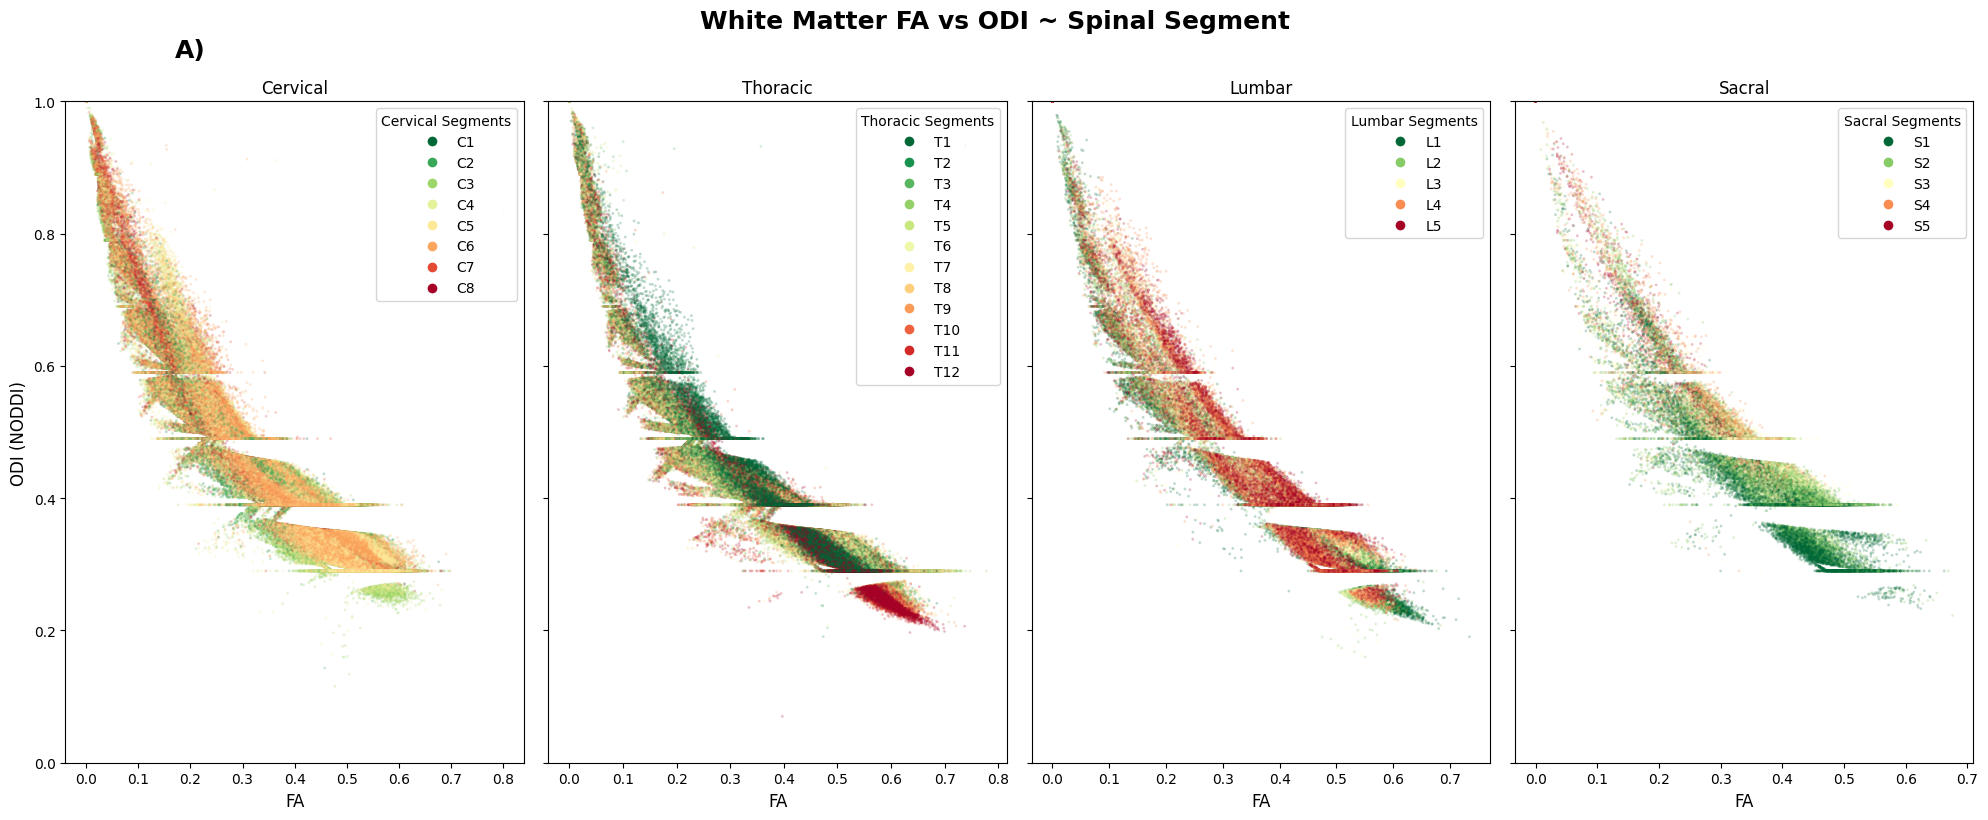

In [153]:
import re
from matplotlib import cm


# Group segments by region
region_map = {'C': [], 'T': [], 'L': [], 'S': []}
for seg in unique_segments:
    region_map[seg[0]].append(seg)

region_labels = ['C', 'T', 'L', 'S']
region_titles = {'C': 'Cervical', 'T': 'Thoracic', 'L': 'Lumbar', 'S': 'Sacral'}

# Natural sort key for segments like 'C1','C10','T2', etc.
def seg_num(seg):
    m = re.search(r'(\d+)', seg)
    return int(m.group(1)) if m else 0

cmap = cm.get_cmap('RdYlGn_r')  # green -> red

fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharey=True)

for i, region in enumerate(region_labels):
    # Segments in this region, sorted rostral->caudal
    segs_in_region = sorted(region_map[region], key=seg_num)
    nseg = len(segs_in_region)

    # Assign each segment a color along the green->red gradient
    # (evenly spaced across the colormap)
    if nseg > 1:
        colors_for_segs = {seg: cmap(j/(nseg-1)) for j, seg in enumerate(segs_in_region)}
    else:
        colors_for_segs = {segs_in_region[0]: cmap(0.5)}

    # Mask voxels belonging to this region and color by their segment
    region_mask = np.isin(wm_segments, segs_in_region)
    seg_labels_region = np.array(wm_segments)[region_mask]
    point_colors = [colors_for_segs[seg] for seg in seg_labels_region]

    axes[i].scatter(
        fa_wm[region_mask],
        odi_wm[region_mask],
        c=point_colors,
        alpha=0.25,
        s=4,
        linewidths=0
    )

    axes[i].set_title(region_titles[region])
    axes[i].set_xlabel('FA', fontsize=12)
    if i == 0:
        axes[i].set_ylabel('ODI (NODDI)', fontsize=12)
    axes[i].set_ylim(0, 1)
    # Legend: one handle per segment with its gradient color
    handles = [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=colors_for_segs[seg], markersize=8, label=seg)
        for seg in segs_in_region
    ]
    axes[i].legend(handles=handles, title=f"{region_titles[region]} Segments",
                   loc='upper right', fontsize='medium', title_fontsize='medium')

fig.suptitle('White Matter FA vs ODI ~ Spinal Segment', fontweight = "bold",fontsize=18, y=1.02)
fig.text(0.09,0.96,"A)", fontsize=18, fontweight='bold' )


plt.savefig('figures/NODDI/WM_FA_vs_ODI_by_Spinal_Segment_Regions.png', dpi=2000, bbox_inches='tight')
plt.tight_layout()
plt.show()


## Combned Stuff

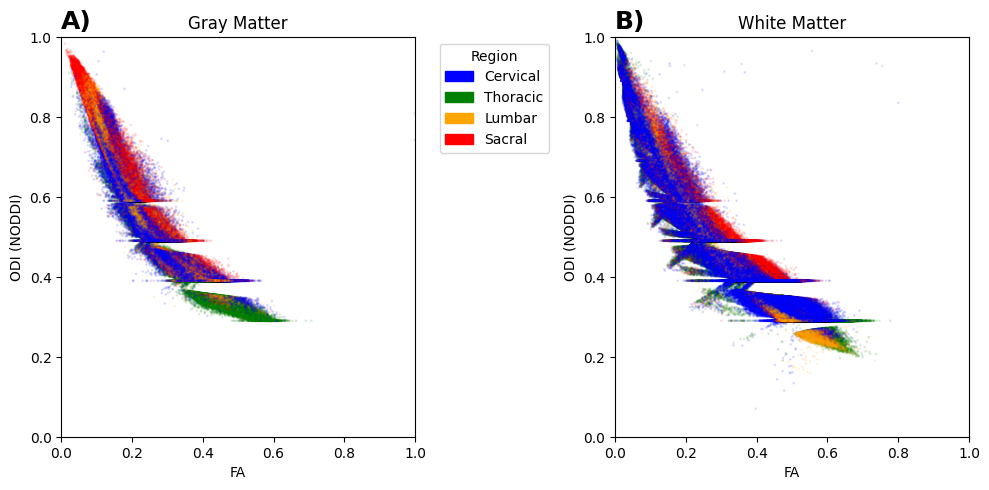

In [61]:
# Assign region color for each GM voxel based on its segment
region_color_map = {'C': 'blue', 'T': 'green', 'L': 'orange', 'S': 'red'}
region_title_map = {'C': 'Cervical', 'T': 'Thoracic', 'L': 'Lumbar', 'S': 'Sacral'}
gm_region = [seg[0] for seg in gm_segments]  # First letter: C, T, L, S
region_colors_gm = [region_color_map[r] for r in gm_region]



fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(fa_gm, odi_gm, c=region_colors_gm, alpha=0.1, s=1)
plt.xlabel('FA')
plt.ylabel('ODI (NODDI)')
plt.title('Gray Matter')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.text(0, 1.02, "A)", fontsize=18, fontweight='bold')

# Add legend with full region names
import matplotlib.patches as mpatches
handles = [
    mpatches.Patch(color=region_color_map[r], label=region_title_map[r])
    for r in region_color_map
]
plt.legend(handles=handles, title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.tight_layout()
#plt.show()


# Assign region color for each GM voxel based on its segment
region_color_map = {'C': 'blue', 'T': 'green', 'L': 'orange', 'S': 'red'}
region_title_map = {'C': 'Cervical', 'T': 'Thoracic', 'L': 'Lumbar', 'S': 'Sacral'}
wm_region = [seg[0] for seg in wm_segments]  # First letter: C, T, L, S
region_colors_wm = [region_color_map[r] for r in wm_region]

plt.subplot(1,2,2)
plt.scatter(fa_wm, odi_wm, c=region_colors_wm, alpha=0.1, s=1)
plt.xlabel('FA')
plt.ylabel('ODI (NODDI)')
plt.title('White Matter')
plt.xlim(0, 1)
plt.text(0, 1.02, "B)", fontsize=18, fontweight='bold')

plt.ylim(0, 1)

# Add legend with full region names
import matplotlib.patches as mpatches
handles = [
    mpatches.Patch(color=region_color_map[r], label=region_title_map[r])
    for r in region_color_map
]
#plt.legend(handles=handles, title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
#fig.text(0.02,0.96,"C)", fontsize=18, fontweight='bold')
plt.savefig('figures/NODDI/GM_and_WM_FA_vs_ODI_by_Region.png', dpi=2000, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.smoothers_lowess import lowess

# Define region color and titles
region_color_map = {'C': 'blue', 'T': 'green', 'L': 'orange', 'S': 'red'}
region_title_map = {'C': 'Cervical', 'T': 'Thoracic', 'L': 'Lumbar', 'S': 'Sacral'}

# Convert to numpy for masking
gm_segments = np.array(gm_segments)
wm_segments = np.array(wm_segments)
fa_gm = np.array(fa_gm)
odi_gm = np.array(odi_gm)
fa_wm = np.array(fa_wm)
odi_wm = np.array(odi_wm)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

def plot_region_data(ax, fa, odi, segments, tissue_type):
    region_stats = {}
    for region, color in region_color_map.items():
        mask = np.array([seg.startswith(region) for seg in segments])
        fa_region = fa[mask]
        odi_region = odi[mask]

        if len(fa_region) == 0:
            continue

        # Scatter
        ax.scatter(fa_region, odi_region, c=color, alpha=0.1, s=1)

        # Density contours
        values = np.vstack([fa_region, odi_region])
        kde = gaussian_kde(values)(values)
        ax.tricontour(fa_region, odi_region, kde, levels=5, colors=color, alpha=0.5, linewidths=0.8)

        # ---- LOWESS smoothing (non-linear trend line) ----
        sorted_idx = np.argsort(fa_region)
        fa_sorted = fa_region[sorted_idx]
        odi_sorted = odi_region[sorted_idx]

        lowess_fit = lowess(odi_sorted, fa_sorted, frac=2/3)  # frac adjusts smoothness
        ax.plot(lowess_fit[:, 0], lowess_fit[:, 1], color=color, linewidth=2)

        # Compute region statistics
        region_stats[region] = {
            "FA_mean": np.mean(fa_region),
            "FA_std": np.std(fa_region),
            "ODI_mean": np.mean(odi_region),
            "ODI_std": np.std(odi_region)
        }

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('FA')
    ax.set_ylabel('ODI (NODDI)')
    ax.set_title(tissue_type)
    return region_stats

# Plot Gray Matter (Panel A)
ax_gm = axes[0]
stats_gm = plot_region_data(ax_gm, fa_gm, odi_gm, gm_segments, 'Gray Matter')
ax_gm.text(0, 1.02, "A)", fontsize=18, fontweight='bold')

# Plot White Matter (Panel B)
ax_wm = axes[1]
stats_wm = plot_region_data(ax_wm, fa_wm, odi_wm, wm_segments, 'White Matter')
ax_wm.text(0, 1.02, "B)", fontsize=18, fontweight='bold')

# Legends
handles = [
    mpatches.Patch(color=region_color_map[r], label=region_title_map[r])
    for r in region_color_map
]
ax_gm.legend(handles=handles, title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('figures/NODDI/GM_WM_FA_ODI_lowess_trends.png', dpi=600, bbox_inches='tight')
plt.show()

# Print region statistics
print("\nGray Matter Statistics (FA and ODI):")
for region, stats in stats_gm.items():
    print(f" {region_title_map[region]}: FA={stats['FA_mean']:.3f}±{stats['FA_std']:.3f}, "
          f"ODI={stats['ODI_mean']:.3f}±{stats['ODI_std']:.3f}")

print("\nWhite Matter Statistics (FA and ODI):")
for region, stats in stats_wm.items():
    print(f" {region_title_map[region]}: FA={stats['FA_mean']:.3f}±{stats['FA_std']:.3f}, "
          f"ODI={stats['ODI_mean']:.3f}±{stats['ODI_std']:.3f}")


## Other Stuff 

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1,3,1)
scatter = plt.scatter(fa_gm,odi_gm, alpha=0.1, s=1)
plt.xlabel('FA')
plt.ylabel('ODI (NODDI)')
plt.title('Gray Matter')
plt.ylim(0,1)

plt.subplot(1,3,2)
scatter = plt.scatter(fa_valid,odi_valid, c=colors, alpha=0.1, s=1)
plt.xlabel('FA')
plt.ylabel('ODI (NODDI)')
plt.title('FA vs ODI Scatter Plot (GM=red, WM=blue)')
plt.ylim(0,1)

# Add legend for colors
red_patch = mpatches.Patch(color='red', label='GM')
blue_patch = mpatches.Patch(color='blue', label='WM')
plt.legend(handles=[red_patch, blue_patch])


plt.subplot(1,3,3)
scatter = plt.scatter(fa_wm,odi_wm, alpha=0.1, s=1)
plt.xlabel('FA')
plt.ylabel('ODI (NODDI)')
plt.title('White Matter)')
plt.ylim(0,1)

plt.tight_layout()
plt.show()

C:\Users\sigur\AppData\Local\Temp\ipykernel_19472\4056477480.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\sigur\miniconda3\envs\DIPY\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


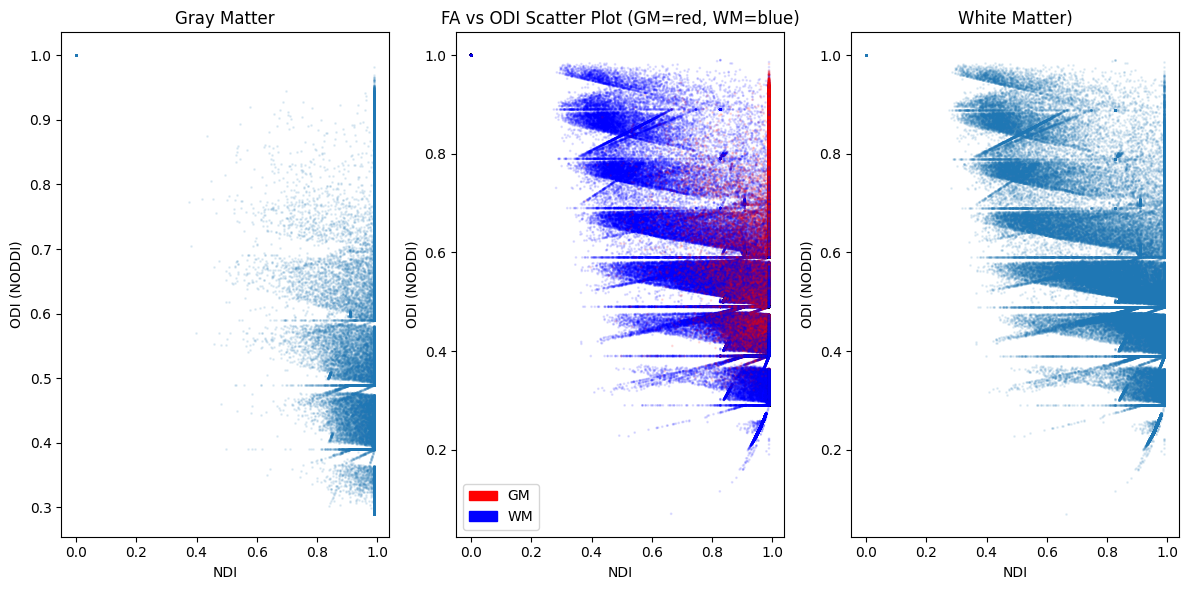

In [84]:
plt.figure(figsize=(12, 6))

plt.subplot(1,3,1)
scatter = plt.scatter(ndi_gm,odi_gm, alpha=0.1, s=1)
plt.xlabel('NDI')
plt.ylabel('ODI (NODDI)')
plt.title('Gray Matter')

plt.subplot(1,3,2)
scatter = plt.scatter(ndi_valid,odi_valid, c=colors, alpha=0.1, s=1)
plt.ylabel('ODI (NODDI)')
plt.xlabel('NDI')
plt.title('FA vs ODI Scatter Plot (GM=red, WM=blue)')

# Add legend for colors
red_patch = mpatches.Patch(color='red', label='GM')
blue_patch = mpatches.Patch(color='blue', label='WM')
plt.legend(handles=[red_patch, blue_patch])


plt.subplot(1,3,3)
scatter = plt.scatter(ndi_wm,odi_wm, alpha=0.1, s=1)
plt.xlabel('NDI')
plt.ylabel('ODI (NODDI)')
plt.title('White Matter)')

plt.tight_layout()
plt.show()

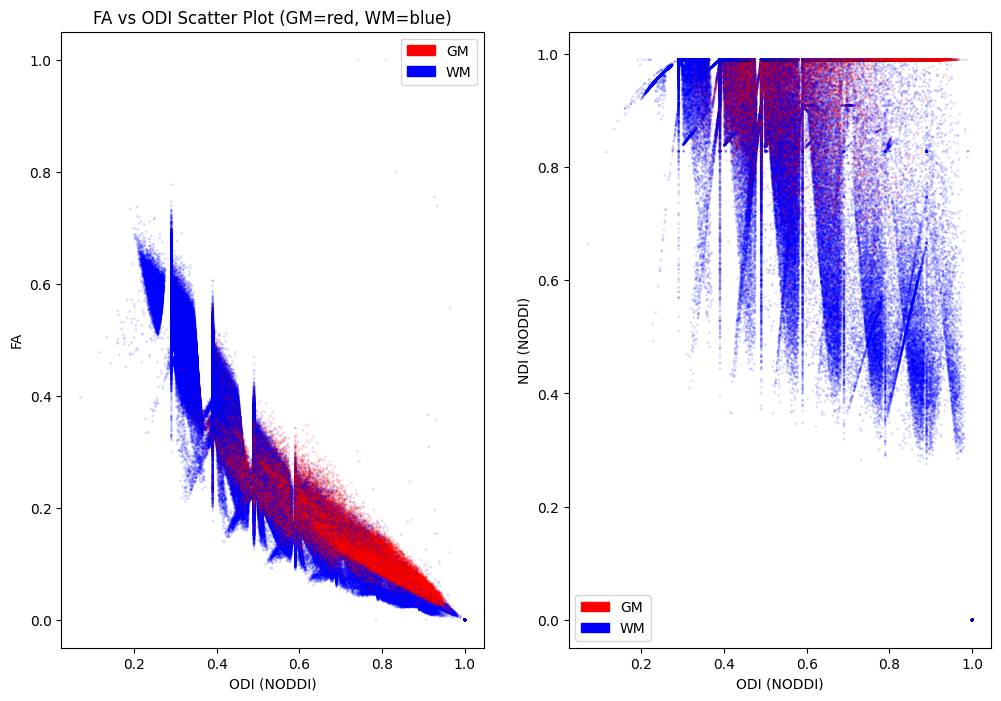

In [73]:
import matplotlib.patches as mpatches

# Define colors: 1=GM (red), 2=WM (blue)
colors = np.where(mask_valid == 1, 'red', 'blue')


plt.figure(figsize=(12, 8))

## Subplot 1
plt.subplot(1,2,1)
scatter = plt.scatter(odi_valid,fa_valid, c=colors, alpha=0.1, s=1)
plt.ylabel('FA')
plt.xlabel('ODI (NODDI)')
plt.title('FA vs ODI Scatter Plot (GM=red, WM=blue)')

# Add legend for colors
red_patch = mpatches.Patch(color='red', label='GM')
blue_patch = mpatches.Patch(color='blue', label='WM')
plt.legend(handles=[red_patch, blue_patch])

## Subplot 2
plt.subplot(1,2,2)
plt.scatter(odi_valid, ndi_valid, c=colors, alpha=0.1, s=1)
plt.ylabel('NDI (NODDI)')
plt.xlabel('ODI (NODDI)')

# Add legend for colors
red_patch = mpatches.Patch(color='red', label='GM')
blue_patch = mpatches.Patch(color='blue', label='WM')
plt.legend(handles=[red_patch, blue_patch])

plt.tight_layout()
plt.show()

c:\Users\sigur\miniconda3\envs\DIPY\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\sigur\miniconda3\envs\DIPY\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


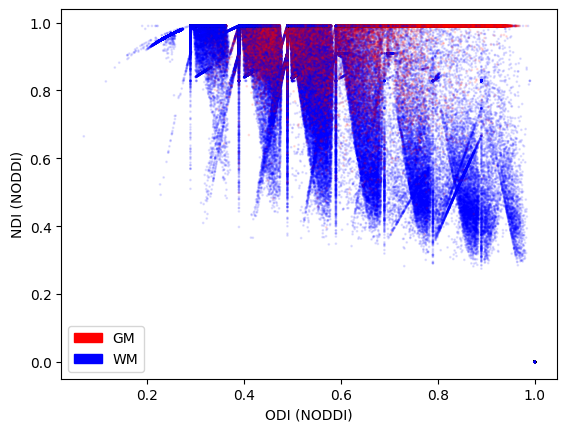

In [ ]:
## Subplot 2
plt.subplot(1,2,2)
plt.scatter(odi_valid, ndi_valid, c=colors, alpha=0.1, s=1)
plt.ylabel('NDI (NODDI)')
plt.xlabel('ODI (NODDI)')

# Add legend for colors
red_patch = mpatches.Patch(color='red', label='GM')
blue_patch = mpatches.Patch(color='blue', label='WM')
plt.legend(handles=[red_patch, blue_patch])

plt.tight_layout()
plt.show()


In [30]:
# Get the FA map from dti_fit
fa_map = dti_fit.fa

# Find indices where ODI_NODDI == 0 but FA < 0.1
idx = np.where((ODI_NODDI == 0) & (fa_map < 0.1))

print(idx)

(array([ 0,  0,  0, ..., 95, 95, 95], shape=(14915853,)), array([ 0,  0,  0, ..., 95, 95, 95], shape=(14915853,)), array([   0,    1,    2, ..., 1802, 1803, 1804], shape=(14915853,)))


# Plot 7: Video for Github

In [5]:
import os
import re

def extract_number(filename):
    match = re.search(r'(\d+)(?=\.\w+$)', filename)
    return int(match.group(1)) if match else -1

# Specify the folder path
folder_path = "C:\\DTI_SC\\humanSC_400h\\figures\\CSD\\Transposed"


# Find all image files (common formats: .png, .jpg, .jpeg, .gif, .tif, .bmp)
image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.tif', '.bmp')
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(image_extensions)]



min_z = 10
max_z = -150

image_files_sorted = sorted(image_files, key=extract_number)

image_files_sorted = image_files_sorted[min_z:max_z]

print("Sorted image files:")
for img in image_files_sorted:
    print(img)

idx_list = [segment_z_index["C8"],
segment_z_index["T12"],
segment_z_index["L5"],
segment_z_index["S5"]]

Sorted image files:
C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs10.png
C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs11.png
C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs12.png
C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs13.png
C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs14.png
C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs15.png
C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs16.png
C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs17.png
C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs18.png
C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs19.png
C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs20.png
C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs21.png
C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs22.png
C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs23.png
C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs24.png
C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs25.png
C:\D

'C8': 435, 'T12': 1454, 'L5': 1683, 'S5': 1804

In [ ]:
import cv2

for i,idx in enumerate(idx_list):
    print(i)
    if i == 0:    
        # Output video path
        output_video_path = "figures/CSD/Z-axis_Video_Cervical_fODF.mp4"
    elif i == 1:
        output_video_path = "figures/CSD/Z-axis_Video_Thoracic_fODF.mp4"
    elif i == 2:
        output_video_path = "figures/CSD/Z-axis_Video_Lumbar_fODF.mp4"
    elif i == 3:
        output_video_path = "figures/CSD/Z-axis_Video_Sacral_fODF.mp4"


    # Read the first image to get frame size
    first_img = cv2.imread(image_files_sorted[idx])
    height, width, layers = first_img.shape

    # Define video writer (codec: mp4v, fps: 6)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video_path, fourcc, 1, (width, height))

    start = idx_list[i-1] if i > 0 else 0
    end = idx_list[i]

    for img_path in image_files_sorted[start:end]:
        print(f"Adding {img_path} to video...")
        frame = cv2.imread(img_path)
        if frame is not None:
            video.write(frame)
        else:
            print(f"Warning: could not read {img_path}")

    video.release()
    print(f"Video saved to {output_video_path}")

0
Adding C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs10.png to video...
Adding C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs11.png to video...
Adding C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs12.png to video...
Adding C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs13.png to video...
Adding C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs14.png to video...
Adding C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs15.png to video...
Adding C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs16.png to video...
Adding C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs17.png to video...
Adding C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs18.png to video...
Adding C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs19.png to video...
Adding C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs20.png to video...
Adding C:\DTI_SC\humanSC_400h\figures\CSD\Transposed\csd_odfs21.png to video...
Adding C:\DTI_SC\humanSC_400h\figures\

In [4]:
import cv2
frame = cv2.imread(image_files_sorted[0])

In [ ]:
import matplotlib.animation as animation

# Specify Input and output paths,
for file in image_files_sorted:
    print(f"Starting file: {file}")
    input_path = file
    output_path = os.path.join("figures/Z-axis Videos", os.path.basename(input_path).replace(".czi", ".gif"))

    if os.path.exists(output_path):
        print(f"Output file {output_path} already exists.---------- Skipping this file ---------")
    else:
        print(f"Output file {output_path} don't exist: ------------ Starting processing ----------")


        # Load in image data,
        image = czifile.imread(input_path)
        


        #Setup the Plot,
        fig, ax = plt.subplots()
        img_display = ax.imshow(image_norm[0], cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title("Slice 0")

        # Animation update function,
        def update_frame(i):
            img_display.set_data(image_norm[i])
            ax.set_title(f"Slice {i}")
            return [img_display]

        # Create animation,
        ani = animation.FuncAnimation(fig, update_frame, frames=image_norm.shape[0], blit=True)

        # Show the animation,
        plt.show()


        # Alternatively, to save as GIF:,
        ani.save(output_path, writer='imagemagick', fps=4)


        output_path = os.path.join("Figures/Z-axis Videos", os.path.basename(input_path).replace(".czi", ".gif"))
        ani.save(output_path, writer='imagemagick', fps=4)

        plt.close(fig)